<a href="https://colab.research.google.com/github/Amika1118/DSGP_Group_38/blob/Market-Price-Prediction/Final_Model_training_with_'XGBoost'%2C_'LightGBM'%2C_'CatBoost'_and_Hyperparameter_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [121]:
%cd /content
!git clone https://github.com/Amika1118/DSGP_Group_38.git
%cd DSGP_Group_38

/content
fatal: destination path 'DSGP_Group_38' already exists and is not an empty directory.
/content/DSGP_Group_38


In [122]:
!git checkout Market-Price-Prediction

Already on 'Market-Price-Prediction'
Your branch is ahead of 'origin/Market-Price-Prediction' by 1 commit.
  (use "git push" to publish your local commits)


In [123]:
!git config --global user.name "Lasani Layathma"
!git config --global user.email "lasani.20241357@iit.ac.lk"

In [124]:
from getpass import getpass
token = getpass("Enter GitHub token: ")
!git remote set-url origin https://{token}@github.com/Amika1118/DSGP_Group_38.git

Enter GitHub token: ··········


In [45]:
!pip install catboost -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Model imports
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                           r2_score, mean_absolute_percentage_error)

# Regression models
import catboost as cb
import xgboost as xgb
import lightgbm as lgb

# For advanced visualizations
from scipy import stats


In [46]:
# Load datasets
retail_df = pd.read_csv('/content/vegetable_prices_pruned_features.csv', parse_dates=['Start_Date'])
wholesale_df = pd.read_csv('/content/wholesale historical data.csv', parse_dates=['Week_Start'])
future_df = pd.read_csv('/content/realistic_weekly_predictions_2026_2040.csv', parse_dates=['Date'])

# Standardize column names
def standardize_columns(df):
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
    return df

retail_df = standardize_columns(retail_df)
wholesale_df = standardize_columns(wholesale_df)
future_df = standardize_columns(future_df)

if 'vegetable_name' in wholesale_df.columns:
    wholesale_df = wholesale_df.rename(columns={'vegetable_name': 'vegetable'})

def standardize_vegetable_names(df):
    if 'vegetable' in df.columns:
        print(f"\nDEBUG for {df.name if hasattr(df, 'name') else 'dataframe'}:")
        print(f"  Before: {df['vegetable'].unique()[:10]}")

        # First, handle the Vegetable_Name column if it exists
        if 'vegetable_name' in df.columns:
            df['vegetable'] = df['vegetable_name']
            df = df.drop(columns=['vegetable_name'])

        # Convert to string and clean
        df['vegetable'] = df['vegetable'].astype(str).str.strip()

        # CORRECTED MAPPING - match exactly what's in your CSVs
        name_mapping = {
            # Retail names → Standard names
            'brinjals': 'Brinjal',
            'tomatoes': 'Tomato',
            'bitter gourd': 'Bitter Gourd',
            'cabbage': 'Cabbage',
            'carrot': 'Carrot',
            'pumpkin': 'Pumpkin',

            # Wholesale names → Standard names (they're already correct)
            'brinjal': 'Brinjal',
            'tomato': 'Tomato',

            # Handle case variations
            'Brinjals': 'Brinjal',
            'Tomatoes': 'Tomato',
            'Brinjal': 'Brinjal',
            'Tomato': 'Tomato',
            'Bitter Gourd': 'Bitter Gourd',
            'Cabbage': 'Cabbage',
            'Carrot': 'Carrot',
            'Pumpkin': 'Pumpkin',

            # Remove NaN/None
            'nan': None,
            'NaN': None,
            'None': None,
        }

        # Apply mapping
        df['vegetable'] = df['vegetable'].map(lambda x: name_mapping.get(x, x))

        # Remove None values
        df = df[df['vegetable'].notna()]

        print(f"  After: {df['vegetable'].unique()}")
        print(f"  Value counts:")
        print(df['vegetable'].value_counts())

    return df

# Apply to all dataframes
retail_df = standardize_vegetable_names(retail_df)
wholesale_df = standardize_vegetable_names(wholesale_df)
future_df = standardize_vegetable_names(future_df)

print("\n AFTER STANDARDIZING VEGETABLE NAMES ")
print(f"Retail vegetables: {retail_df['vegetable'].unique()}")
print(f"Wholesale vegetables: {wholesale_df['vegetable'].unique()}")

# Rename date columns
retail_df = retail_df.rename(columns={'start_date': 'date'})
wholesale_df = wholesale_df.rename(columns={'week_start': 'date'})
future_df = future_df.rename(columns={'week_start': 'date'})

# Merge with additional wholesale features
wholesale_features = [col for col in wholesale_df.columns if col not in ['date', 'vegetable']]
integrated_df = pd.merge(
    retail_df,
    wholesale_df[['date', 'vegetable'] + wholesale_features],
    on=['date', 'vegetable'],
    how='left',
    suffixes=('_retail', '_wholesale')
)

print(f"Integrated dataset: {integrated_df.shape[0]:,} rows × {integrated_df.shape[1]} columns")


DEBUG for dataframe:
  Before: ['Bitter Gourd' 'Brinjals' 'Cabbage' 'Carrot' 'Pumpkin' 'Tomatoes']
  After: ['Bitter Gourd' 'Brinjal' 'Cabbage' 'Carrot' 'Pumpkin' 'Tomato']
  Value counts:
vegetable
Bitter Gourd    1306
Brinjal         1306
Cabbage         1306
Pumpkin         1306
Tomato          1306
Carrot          1254
Name: count, dtype: int64

DEBUG for dataframe:
  Before: ['Bitter Gourd' 'Brinjal' 'Cabbage' 'Carrot' 'Pumpkin' 'Tomato']
  After: ['Bitter Gourd' 'Brinjal' 'Cabbage' 'Carrot' 'Pumpkin' 'Tomato']
  Value counts:
vegetable
Bitter Gourd    838
Brinjal         838
Cabbage         838
Carrot          838
Pumpkin         838
Tomato          838
Name: count, dtype: int64

 AFTER STANDARDIZING VEGETABLE NAMES 
Retail vegetables: ['Bitter Gourd' 'Brinjal' 'Cabbage' 'Carrot' 'Pumpkin' 'Tomato']
Wholesale vegetables: ['Bitter Gourd' 'Brinjal' 'Cabbage' 'Carrot' 'Pumpkin' 'Tomato']
Integrated dataset: 7,790 rows × 121 columns


In [47]:
#  Comprehensive Feature Engineering

# Make a copy
df = integrated_df.copy()

# 1. IDENTIFY TARGET VARIABLE
target_col = 'weekly_price' if 'weekly_price' in df.columns else 'price'
print(f"Target variable identified: {target_col}")

# 2. INITIAL CLEANING - Drop rows with missing target
initial_rows = len(df)
df = df.dropna(subset=[target_col])
print(f"Removed {initial_rows - len(df)} rows with missing target values")

# 3. TEMPORAL FEATURES
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['week_of_year'] = df['date'].dt.isocalendar().week
df['quarter'] = df['date'].dt.quarter
df['day_of_year'] = df['date'].dt.dayofyear

# Cyclical encoding for temporal features
df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
df['week_sin'] = np.sin(2 * np.pi * df['week_of_year']/52)
df['week_cos'] = np.cos(2 * np.pi * df['week_of_year']/52)

# 4. PRICE DYNAMICS FEATURES WITH PROPER NaN HANDLING
# First, ensure data is sorted
df = df.sort_values(['vegetable', 'date'])

# Create lag features with forward fill for each vegetable group
essential_lags = [1, 4, 12]  # Weekly, monthly, quarterly
for lag in essential_lags:
    df[f'price_lag_{lag}'] = df.groupby('vegetable')[target_col].shift(lag)

# Price changes with forward fill
df['price_change_1w'] = df.groupby('vegetable')[target_col].pct_change(1)
df['price_change_4w'] = df.groupby('vegetable')[target_col].pct_change(4)

# Rolling statistics with proper min_periods
essential_windows = [4, 12]  # Monthly and quarterly
for window in essential_windows:
    df[f'price_rolling_mean_{window}'] = df.groupby('vegetable')[target_col].transform(
        lambda x: x.rolling(window, min_periods=2).mean()
    )
    df[f'price_rolling_std_{window}'] = df.groupby('vegetable')[target_col].transform(
        lambda x: x.rolling(window, min_periods=2).std()
    )

# 5. TECHNICAL INDICATORS with fillna
df['price_sma_4'] = df.groupby('vegetable')[target_col].transform(
    lambda x: x.rolling(4, min_periods=2).mean()
)
df['price_sma_12'] = df.groupby('vegetable')[target_col].transform(
    lambda x: x.rolling(12, min_periods=2).mean()
)

# Price momentum with fillna for division issues
df['price_momentum_4'] = np.where(df['price_lag_4'] != 0,
                                   df[target_col] / df['price_lag_4'] - 1,
                                   0)

# 6. WHOLESALE-RETAIL RELATIONSHIP
if 'avg_weekly_price' in df.columns:
    # Fill NaN in avg_weekly_price with forward/backward fill by vegetable
    df['avg_weekly_price'] = df.groupby('vegetable')['avg_weekly_price'].transform(
        lambda x: x.ffill().bfill()
    )

    # Calculate ratio with protection against division by zero
    df['retail_wholesale_ratio'] = np.where(df['avg_weekly_price'] > 0,
                                            df[target_col] / df['avg_weekly_price'],
                                            1)
    df['retail_wholesale_spread'] = df[target_col] - df['avg_weekly_price']

# 7. SEASONALITY INDICATORS
df['is_spring'] = df['month'].isin([3, 4, 5]).astype(int)
df['is_monsoon'] = df['month'].isin([6, 7, 8]).astype(int)
df['is_festive'] = df['month'].isin([9, 10, 11]).astype(int)

# 8. COMPREHENSIVE NaN HANDLING
print("\nHandling NaN values in features...")

# Fill NaN in price dynamics features with appropriate methods
price_features = [col for col in df.columns if 'price' in col.lower() and col != target_col]
for feature in price_features:
    if feature in df.columns:
        missing_before = df[feature].isna().sum()
        # Use forward fill within each vegetable group, then backward fill
        df[feature] = df.groupby('vegetable')[feature].transform(lambda x: x.bfill())
        # If still NaN, fill with mean by vegetable
        if df[feature].isna().any():
            vegetable_means = df.groupby('vegetable')[feature].transform('mean')
            df[feature] = df[feature].fillna(vegetable_means)
        # If still NaN, fill with overall mean
        df[feature] = df[feature].fillna(df[feature].mean())
        missing_after = df[feature].isna().sum()
        if missing_before > 0:
            print(f"  Filled {missing_before - missing_after} NaN values in {feature}")

# 9. FINAL CLEANING - Drop any remaining NaN rows
final_rows_before = len(df)
df = df.dropna()
final_rows_after = len(df)
print(f"\nFinal cleaning: Removed {final_rows_before - final_rows_after} rows with NaN values")

print(f"\nFeature engineering complete: {df.shape[1]} columns created")
print(f"Final dataset: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"NaN values remaining: {df.isna().sum().sum()}")

Target variable identified: weekly_price
Removed 0 rows with missing target values

Handling NaN values in features...
  Filled 3074 NaN values in std_weekly_price
  Filled 3074 NaN values in min_weekly_price
  Filled 3074 NaN values in max_weekly_price
  Filled 3074 NaN values in avg_weekly_price_lag_1w
  Filled 3074 NaN values in avg_weekly_price_lag_2w
  Filled 3074 NaN values in avg_weekly_price_lag_4w
  Filled 3074 NaN values in avg_weekly_price_lag_8w
  Filled 3074 NaN values in avg_weekly_price_lag_12w
  Filled 3074 NaN values in avg_weekly_price_lag_26w
  Filled 3074 NaN values in avg_weekly_price_lag_52w
  Filled 3074 NaN values in avg_weekly_price_ma_4w
  Filled 3074 NaN values in avg_weekly_price_ma_8w
  Filled 3074 NaN values in avg_weekly_price_ma_12w
  Filled 3074 NaN values in avg_weekly_price_ma_26w
  Filled 3074 NaN values in price_change_pct
  Filled 3074 NaN values in price_arrival_elasticity
  Filled 3074 NaN values in log_price_arrival_elasticity
  Filled 3074 NaN 

In [48]:
# Feature Selection and Data Preparation

print("Selecting relevant features and preparing data")

# 1. Separate features and target
exclude_cols = [target_col, 'date', 'vegetable']
X = df.drop(columns=[col for col in exclude_cols if col in df.columns])
y = df[target_col]

print(f"Initial features: {X.shape[1]} columns")

# 2. Keep only numeric columns
X = X.select_dtypes(include=[np.number])

# 3. Final NaN check and fill
print(f"NaN values in features before filling: {X.isna().sum().sum()}")
if X.isna().sum().sum() > 0:
    print("Filling remaining NaN values with column medians...")
    X = X.fillna(X.median())

print(f"NaN values after filling: {X.isna().sum().sum()}")

# 4. Remove constant and low variance features
from sklearn.feature_selection import VarianceThreshold

# Remove constant features
constant_filter = VarianceThreshold(threshold=0)
X_no_constant = constant_filter.fit_transform(X)
constant_features = X.columns[~constant_filter.get_support()]
print(f"Removed {len(constant_features)} constant features")

# Remove low variance features (optional)
variance_filter = VarianceThreshold(threshold=0.01)
X_filtered = variance_filter.fit_transform(X_no_constant)
low_variance_features = constant_filter.get_feature_names_out()[~variance_filter.get_support()]
print(f"Removed {len(low_variance_features)} low variance features")

# Create new DataFrame with filtered features
X_filtered_df = pd.DataFrame(X_filtered,
                             columns=variance_filter.get_feature_names_out(),
                             index=X.index)

# 5. Feature selection using correlation (NO mutual_info_regression to avoid errors)
print("\nPerforming feature selection using correlation...")

# Calculate correlation with target
correlation_with_target = X_filtered_df.corrwith(y).abs().sort_values(ascending=False)

# Select top features based on correlation
n_features_to_select = min(30, len(correlation_with_target))
top_features = correlation_with_target.head(n_features_to_select).index.tolist()

print(f"Selected {len(top_features)} top features based on correlation")
print(f"\nTop 10 features by correlation:")
for i, (feature, corr) in enumerate(correlation_with_target.head(10).items(), 1):
    print(f"{i:2}. {feature}: {corr:.4f}")

X_selected = X_filtered_df[top_features]

print(f"\nFinal feature matrix shape: {X_selected.shape}")
print(f"Target shape: {y.shape}")

Selecting relevant features and preparing data
Initial features: 139 columns
NaN values in features before filling: 0
NaN values after filling: 0
Removed 0 constant features
Removed 6 low variance features

Performing feature selection using correlation...
Selected 30 top features based on correlation

Top 10 features by correlation:
 1. x117: 0.9917
 2. x19: 0.9917
 3. x122: 0.9832
 4. x126: 0.9832
 5. x17: 0.9828
 6. x7: 0.9828
 7. x13: 0.9750
 8. x6: 0.9683
 9. x130: 0.9662
10. x8: 0.9339

Final feature matrix shape: (4716, 30)
Target shape: (4716,)


In [49]:
#Time Series Split

print("Creating time series splits with validation windows")

# Add date back for sorting
X_with_date = X_selected.copy()
X_with_date['date'] = df['date'].values

# Sort by date
sorted_idx = X_with_date.sort_values('date').index
X_sorted = X_selected.loc[sorted_idx]
y_sorted = y.loc[sorted_idx]
dates_sorted = df['date'].loc[sorted_idx]

# Create expanding window splits
train_size = int(len(X_sorted) * 0.6)  # 60% for initial training
val_size = int(len(X_sorted) * 0.2)    # 20% for validation
test_size = len(X_sorted) - train_size - val_size  # 20% for testing

print(f"Dataset size: {len(X_sorted):,}")
print(f"Initial Train: {train_size:,} ({train_size/len(X_sorted)*100:.1f}%)")
print(f"Validation: {val_size:,} ({val_size/len(X_sorted)*100:.1f}%)")
print(f"Test: {test_size:,} ({test_size/len(X_sorted)*100:.1f}%)")

# Split indices
train_idx = slice(0, train_size)
val_idx = slice(train_size, train_size + val_size)
test_idx = slice(train_size + val_size, None)

# Create splits
X_train = X_sorted.iloc[train_idx]
y_train = y_sorted.iloc[train_idx]
dates_train = dates_sorted.iloc[train_idx]

X_val = X_sorted.iloc[val_idx]
y_val = y_sorted.iloc[val_idx]
dates_val = dates_sorted.iloc[val_idx]

X_test = X_sorted.iloc[test_idx]
y_test = y_sorted.iloc[test_idx]
dates_test = dates_sorted.iloc[test_idx]

print(f"\nDate ranges:")
print(f"  Train: {dates_train.min().date()} to {dates_train.max().date()}")
print(f"  Val: {dates_val.min().date()} to {dates_val.max().date()}")
print(f"  Test: {dates_test.min().date()} to {dates_test.max().date()}")

Creating time series splits with validation windows
Dataset size: 4,716
Initial Train: 2,829 (60.0%)
Validation: 943 (20.0%)
Test: 944 (20.0%)

Date ranges:
  Train: 2009-12-28 to 2019-01-07
  Val: 2019-01-07 to 2022-01-10
  Test: 2022-01-10 to 2025-01-06


In [50]:
# Feature Scaling and Data Transformation

from sklearn.preprocessing import RobustScaler

# Scale features (RobustScaler handles outliers better)
scaler_X = RobustScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = y_train.values
y_val_scaled = y_val.values
y_test_scaled = y_test.values

print("Features and target scaled using RobustScaler")
print(f"  Training set shape: {X_train_scaled.shape}")
print(f"  Validation set shape: {X_val_scaled.shape}")
print(f"  Test set shape: {X_test_scaled.shape}")

Features and target scaled using RobustScaler
  Training set shape: (2829, 30)
  Validation set shape: (943, 30)
  Test set shape: (944, 30)


In [51]:
# 1. XGBoost with learning rate decay
xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=7,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    eval_metric=['rmse', 'mae'],
    early_stopping_rounds=50
)

xgb_model.fit(
    X_train_scaled, y_train_scaled,
    eval_set=[(X_val_scaled, y_val_scaled)],
    verbose=False
)

# Store training history
xgb_history = xgb_model.evals_result()

In [52]:
# 2. LightGBM with learning rate analysis
lgb_model = lgb.LGBMRegressor(
    n_estimators=500,
    max_depth=7,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    verbose=-1,
    num_leaves=31,
    feature_fraction=1.0,
    min_child_samples=20
)

print("2. Training LightGBM")
lgb_model.fit(
    X_train_scaled, y_train_scaled,
    eval_set=[(X_val_scaled, y_val_scaled)],
    eval_metric=['l2', 'l1'],
    callbacks=[lgb.log_evaluation(0)]
)

lgb_history = lgb_model.evals_result_


2. Training LightGBM


In [53]:
# 3. CatBoost
print("3. Training CatBoost...")
cat_model = cb.CatBoostRegressor(
    iterations=500,
    depth=7,
    learning_rate=0.05,
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=42,
    verbose=100,
    task_type='CPU',
    early_stopping_rounds=50,
    cat_features=None,
    l2_leaf_reg=3.0,
    bootstrap_type='Bernoulli',
    subsample=0.8
)

cat_model.fit(
    X_train_scaled, y_train_scaled,
    eval_set=(X_val_scaled, y_val_scaled),
    use_best_model=True,
    plot=False
)

# Store history
cat_history = cat_model.get_evals_result()

# Store all models
models = {
    'XGBoost': {'model': xgb_model, 'history': xgb_history},
    'LightGBM': {'model': lgb_model, 'history': lgb_history},
    'CatBoost': {'model': cat_model, 'history': cat_history}
    }

3. Training CatBoost...
0:	learn: 52.3537117	test: 95.4783050	best: 95.4783050 (0)	total: 45.4ms	remaining: 22.7s
100:	learn: 4.8759085	test: 30.0348816	best: 30.0348816 (100)	total: 2.08s	remaining: 8.23s
200:	learn: 3.0613262	test: 28.1585347	best: 28.1585347 (200)	total: 4.54s	remaining: 6.75s
300:	learn: 2.2697487	test: 27.8042738	best: 27.8042738 (300)	total: 8.13s	remaining: 5.38s
400:	learn: 1.8433525	test: 27.6138899	best: 27.6125593 (398)	total: 11s	remaining: 2.71s
499:	learn: 1.5481024	test: 27.5100322	best: 27.5085687 (489)	total: 13.3s	remaining: 0us

bestTest = 27.50856869
bestIteration = 489

Shrink model to first 490 iterations.


In [54]:
# Setup and Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib as mpl

plt.style.use('seaborn-v0_8-whitegrid')
mpl.rcParams.update({
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'font.size': 10,
    'axes.titlesize': 12,
    'axes.labelsize': 10,
    'legend.fontsize': 9,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.linestyle': '--'
})

# color palette
COLORS = {
    'primary': ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'],
    'models': {
        'XGBoost': '#1f77b4',
        'LightGBM': '#ff7f0e',
        'CatBoost': '#9467bd'
    }
}

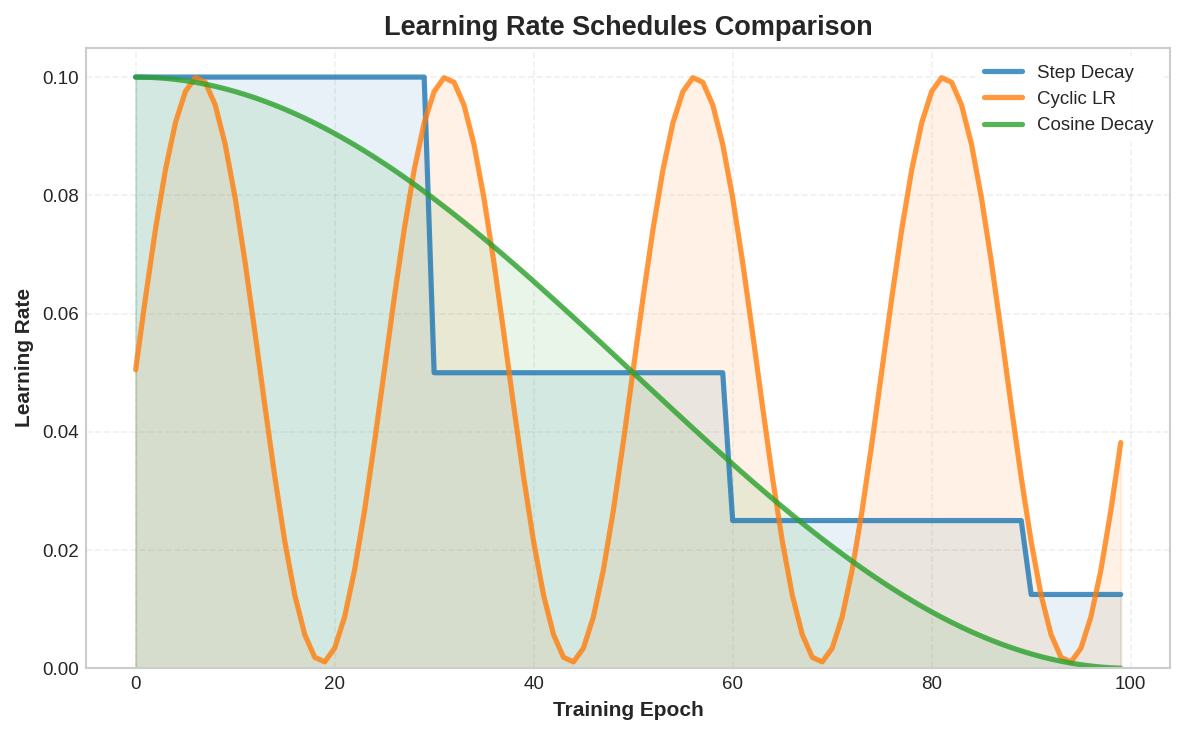

In [55]:
# Learning Rate Schedules Visualization
fig, ax = plt.subplots(figsize=(8, 5))

epochs = np.arange(100)
schedules = {
    'Step Decay': [0.1 * (0.5 ** (e // 30)) for e in epochs],
    'Cyclic LR': [0.001 + 0.099 * (1 + np.sin(2 * np.pi * e / 25)) / 2 for e in epochs],
    'Cosine Decay': [0.1 * 0.5 * (1 + np.cos(np.pi * e / 100)) for e in epochs]
}

for (name, lr), color in zip(schedules.items(), COLORS['primary']):
    ax.plot(epochs, lr, color=color, linewidth=2.5, label=name, alpha=0.8)
    ax.fill_between(epochs, 0, lr, color=color, alpha=0.1)

ax.set_xlabel('Training Epoch', fontweight='semibold')
ax.set_ylabel('Learning Rate', fontweight='semibold')
ax.set_title('Learning Rate Schedules Comparison', fontsize=13, fontweight='bold')
ax.legend(frameon=True, framealpha=0.9, edgecolor='white')
ax.set_ylim(bottom=0)

plt.tight_layout()
plt.savefig('learning_rate_schedules.png', dpi=300, bbox_inches='tight')
plt.show()

 Learning Rate Schedules:
Shows different strategies for adjusting learning rates during training. Step decay reduces LR at fixed intervals, cyclic oscillates between bounds (helps escape local minima), and cosine provides smooth decay.

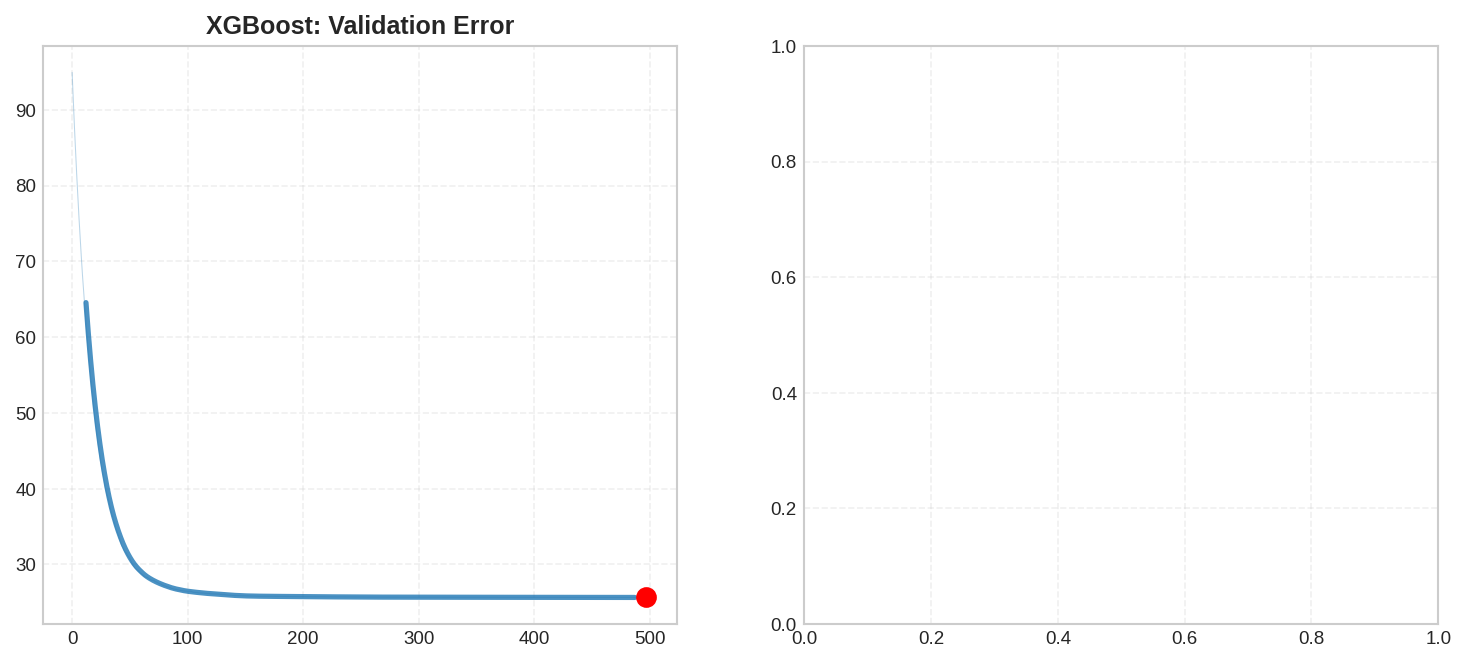

In [56]:
#  XGBoost Training Progress
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# XGBoost Progress
if 'validation_0' in xgb_history:
    rmse_vals = xgb_history['validation_0']['rmse']
    epochs_xgb = np.arange(len(rmse_vals))

    # Smooth curve
    rmse_smooth = pd.Series(rmse_vals).rolling(window=max(1, len(rmse_vals)//20),
                                               center=True).mean()

    ax1.plot(epochs_xgb, rmse_smooth, color=COLORS['models']['XGBoost'],
             linewidth=2.5, alpha=0.8, label='Smoothed')
    ax1.plot(epochs_xgb, rmse_vals, color=COLORS['models']['XGBoost'],
             linewidth=0.5, alpha=0.3, label='Actual')

    # Mark minimum
    min_idx = np.argmin(rmse_vals)
    ax1.scatter(min_idx, rmse_vals[min_idx], color='red', s=80, zorder=5,
                label=f'Min: {rmse_vals[min_idx]:.3f}')

    ax1.set_title('XGBoost: Validation Error', fontweight='bold')

 XGBoost Training Progress:
Tracks how validation error decreases with each boosting round. Should show steady improvement then plateau when model converges.

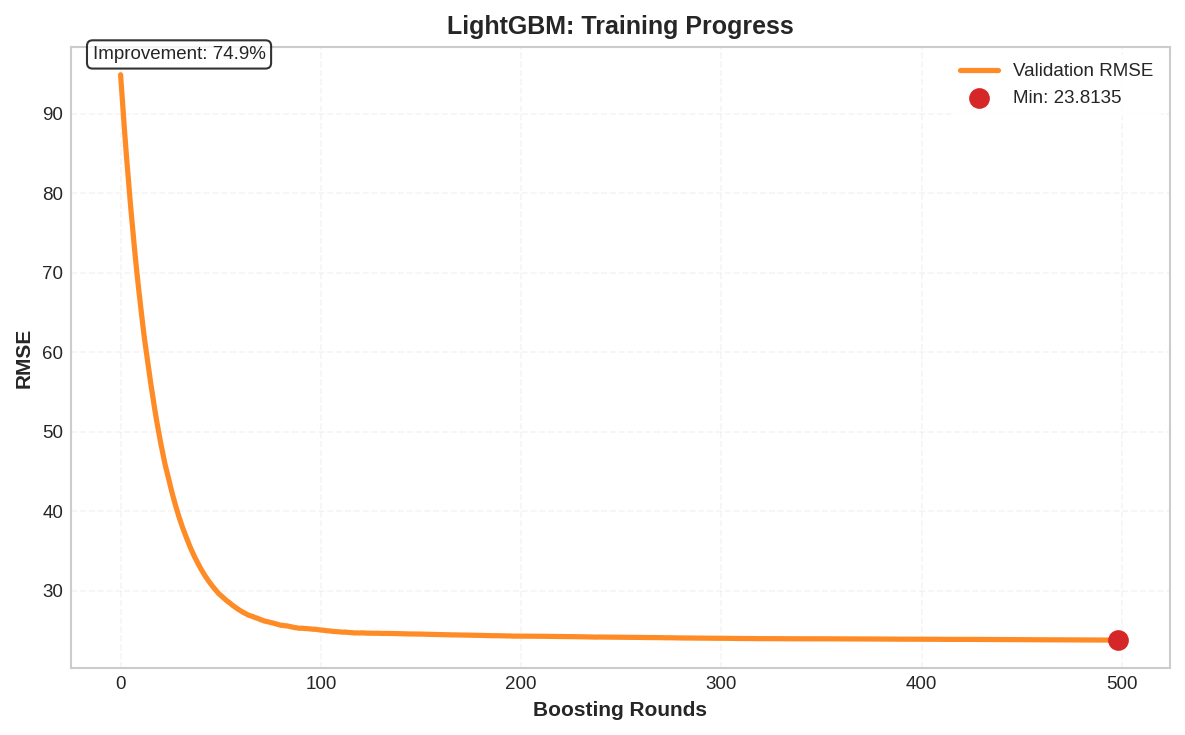

In [57]:
#  LightGBM Training Progress
fig, ax = plt.subplots(figsize=(8, 5))

if 'valid_0' in lgb_history:
    # Get data
    rmse = np.sqrt(lgb_history['valid_0']['l2'])
    epochs = np.arange(len(rmse))

    # Plot
    ax.plot(epochs, rmse, color=COLORS['models']['LightGBM'],
            linewidth=2.5, alpha=0.9, label='Validation RMSE')

    # Mark minimum
    min_idx = np.argmin(rmse)
    ax.scatter(min_idx, rmse[min_idx], color='#d62728', s=80,
               zorder=5, label=f'Min: {rmse[min_idx]:.4f}')

    # Formatting
    ax.set_xlabel('Boosting Rounds', fontweight='semibold')
    ax.set_ylabel('RMSE', fontweight='semibold')
    ax.set_title('LightGBM: Training Progress', fontweight='bold')
    ax.legend(frameon=True, edgecolor='white')
    ax.grid(True, alpha=0.2, linestyle='--')

    # Add improvement text
    if len(rmse) > 1:
        improvement = (rmse[0] - rmse[-1]) / rmse[0] * 100
        ax.text(0.02, 0.98, f'Improvement: {improvement:.1f}%',
                transform=ax.transAxes, fontsize=9,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
else:
    ax.text(0.5, 0.5, 'No training data', ha='center', va='center', color='gray')
    ax.set_axis_off()

plt.tight_layout()
plt.show()

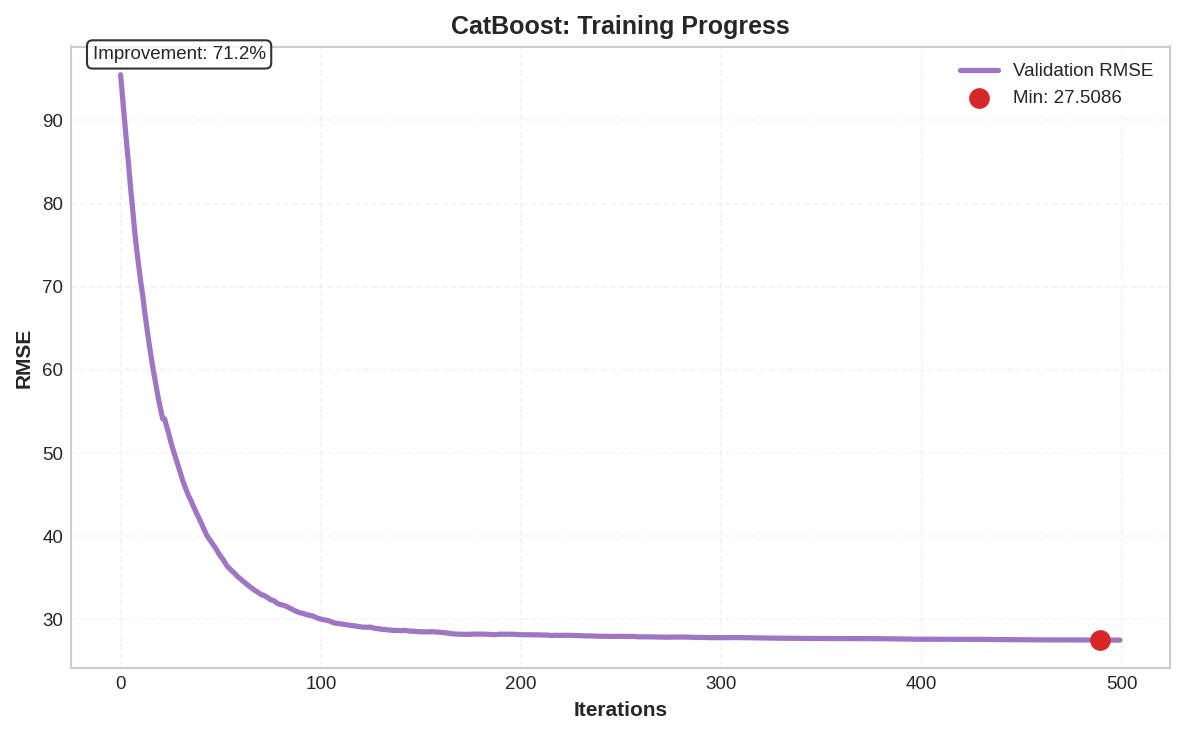

In [58]:
# CatBoost Training Progress
if cat_history and 'validation' in cat_history and 'RMSE' in cat_history['validation']:
    fig, ax = plt.subplots(figsize=(8, 5))

    # Get data
    rmse = cat_history['validation']['RMSE']
    iterations = np.arange(len(rmse))

    # Plot
    ax.plot(iterations, rmse, color=COLORS['models']['CatBoost'],
            linewidth=2.5, alpha=0.9, label='Validation RMSE')

    # Mark minimum
    min_idx = np.argmin(rmse)
    ax.scatter(min_idx, rmse[min_idx], color='#d62728', s=80,
               zorder=5, label=f'Min: {rmse[min_idx]:.4f}')

    # Formatting
    ax.set_xlabel('Iterations', fontweight='semibold')
    ax.set_ylabel('RMSE', fontweight='semibold')
    ax.set_title('CatBoost: Training Progress', fontweight='bold')
    ax.legend(frameon=True, edgecolor='white')
    ax.grid(True, alpha=0.2, linestyle='--')

    # Add improvement text
    if len(rmse) > 1:
        improvement = (rmse[0] - rmse[-1]) / rmse[0] * 100
        ax.text(0.02, 0.98, f'Improvement: {improvement:.1f}%',
                transform=ax.transAxes, fontsize=9,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()

 LightGBM Training Progress:
Similar to XGBoost but for LightGBM. Shows error reduction over iterations.

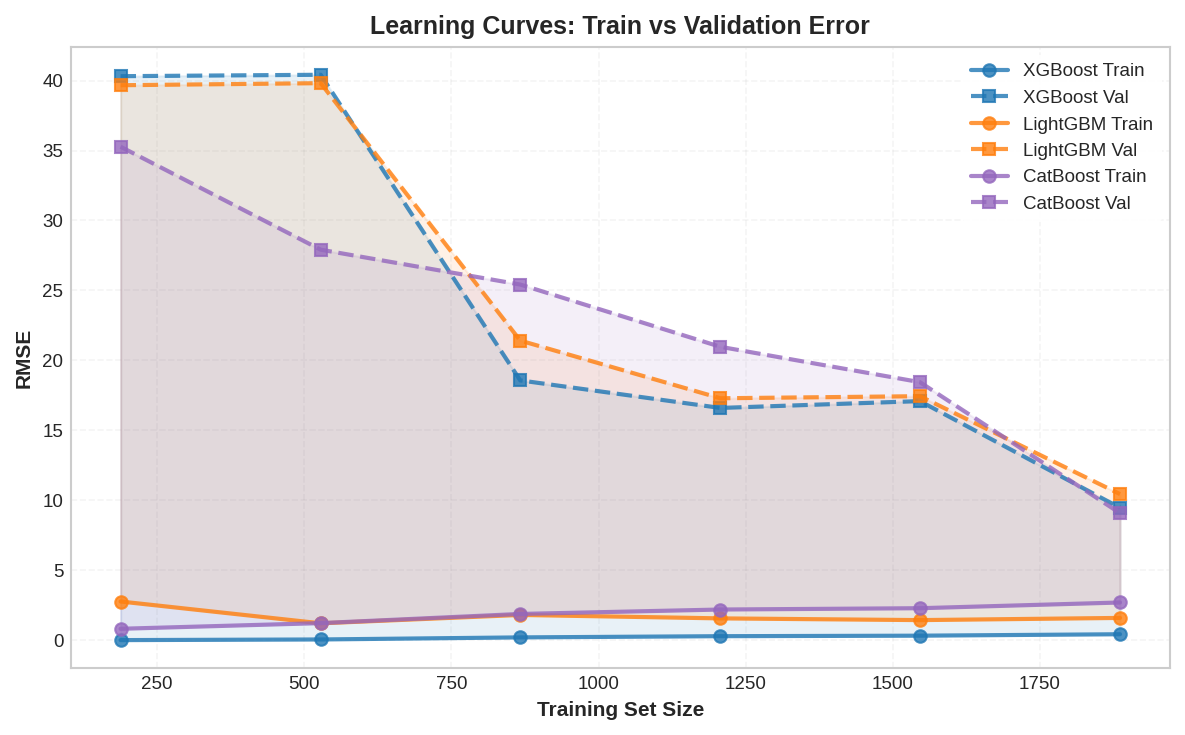

In [59]:
# Learning Curves (Training vs Validation Error)
fig, ax = plt.subplots(figsize=(8, 5))

# Model definitions
simple_models = {
    'XGBoost': xgb.XGBRegressor(n_estimators=200, max_depth=7,
                                learning_rate=0.05, random_state=42, n_jobs=-1),
    'LightGBM': lgb.LGBMRegressor(n_estimators=200, max_depth=7,
                                  learning_rate=0.05, random_state=42,
                                  n_jobs=-1, verbose=-1),
    'CatBoost': cb.CatBoostRegressor(iterations=200, depth=7,
                                    learning_rate=0.05, random_seed=42,
                                    verbose=False, loss_function='RMSE')
}

# Plot learning curves
model_colors = {
    'XGBoost': COLORS['models']['XGBoost'],
    'LightGBM': COLORS['models']['LightGBM'],
    'CatBoost': '#9467bd'
}

for name, color in model_colors.items():
    try:
        model = simple_models[name]
        train_sizes, train_scores, val_scores = learning_curve(
            model, X_train_scaled, y_train_scaled,
            cv=3, scoring='neg_mean_squared_error',
            train_sizes=np.linspace(0.1, 1.0, 6),
            n_jobs=-1, random_state=42
        )

        # Calculate RMSE
        train_rmse = np.sqrt(-train_scores.mean(axis=1))
        val_rmse = np.sqrt(-val_scores.mean(axis=1))

        # Plot with style
        ax.plot(train_sizes, train_rmse, 'o-', color=color,
                linewidth=2, markersize=6, label=f'{name} Train', alpha=0.8)
        ax.plot(train_sizes, val_rmse, 's--', color=color,
                linewidth=2, markersize=6, label=f'{name} Val', alpha=0.8)

        # Fill gap between train and validation
        ax.fill_between(train_sizes, train_rmse, val_rmse,
                       color=color, alpha=0.1)

    except Exception as e:
        print(f"Error with {name}: {e}")

# Formatting
ax.set_xlabel('Training Set Size', fontweight='semibold')
ax.set_ylabel('RMSE', fontweight='semibold')
ax.set_title('Learning Curves: Train vs Validation Error', fontweight='bold')
ax.legend(frameon=True, framealpha=0.9, edgecolor='white')
ax.grid(True, alpha=0.2, linestyle='--')

plt.tight_layout()
plt.savefig('learning_curves.png', dpi=300, bbox_inches='tight')
plt.show()

Learning Curves:
Compares training vs validation error as training data increases. Gap between lines indicates overfitting (large gap) or underfitting (both high).

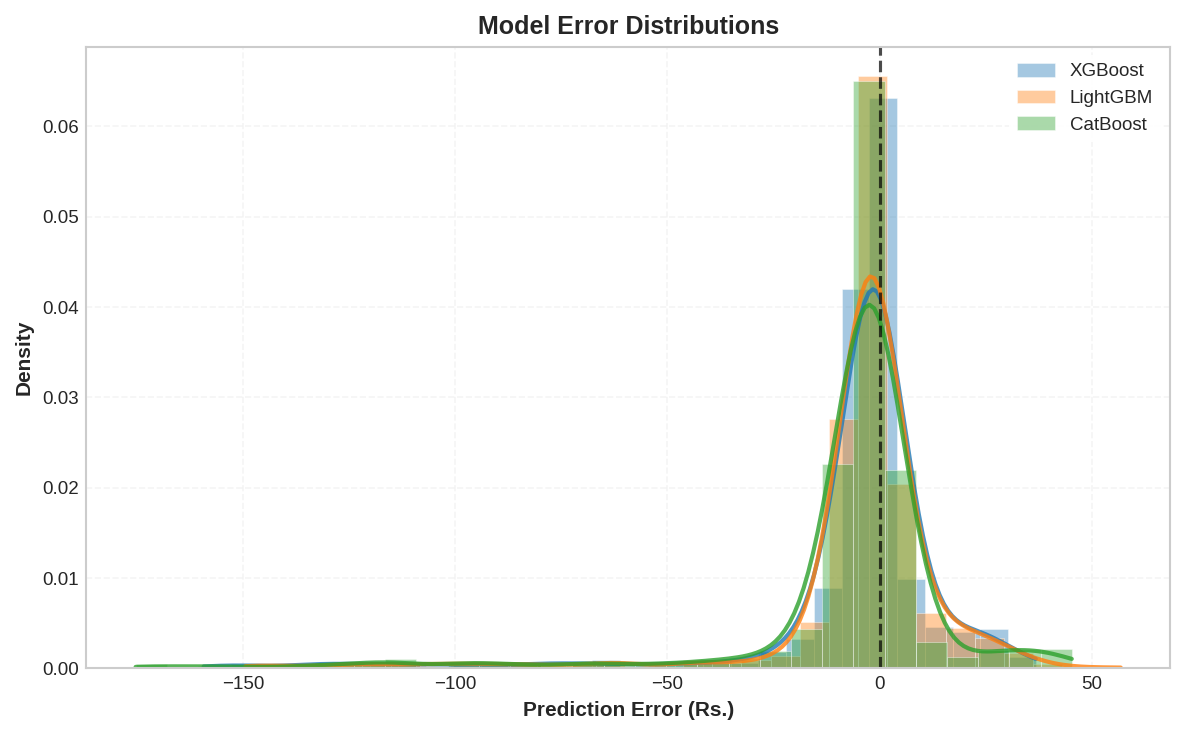

In [60]:
# Error Distribution Comparison
fig, ax = plt.subplots(figsize=(8, 5))

# Get error distributions
error_data = []
model_names = []

for name, model_info in models.items():
    model = model_info['model']

    # Get predictions
    pred = model.predict(X_val_scaled)

    # Calculate errors
    errors = pred - y_val.values
    error_data.append(errors)
    model_names.append(name)

# Plot with KDE
for errors, name, color in zip(error_data, model_names, COLORS['primary']):
    # Histogram
    ax.hist(errors, bins=30, alpha=0.4, label=name, density=True,
            color=color, edgecolor='white', linewidth=0.5)

    # KDE overlay
    kde = stats.gaussian_kde(errors)
    x_range = np.linspace(errors.min(), errors.max(), 200)
    ax.plot(x_range, kde(x_range), color=color, linewidth=2, alpha=0.8)

# Zero line
ax.axvline(x=0, color='black', linestyle='--', linewidth=1.5, alpha=0.7)

# Formatting
ax.set_xlabel('Prediction Error (Rs.)', fontweight='semibold')
ax.set_ylabel('Density', fontweight='semibold')
ax.set_title('Model Error Distributions', fontweight='bold')
ax.legend(frameon=True, framealpha=0.9, edgecolor='white')
ax.grid(True, alpha=0.2, linestyle='--')

plt.tight_layout()
plt.savefig('error_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

 Error Distribution:
Shows frequency of prediction errors. Ideally centered at 0 with normal distribution. Wide spread indicates high variance in predictions.

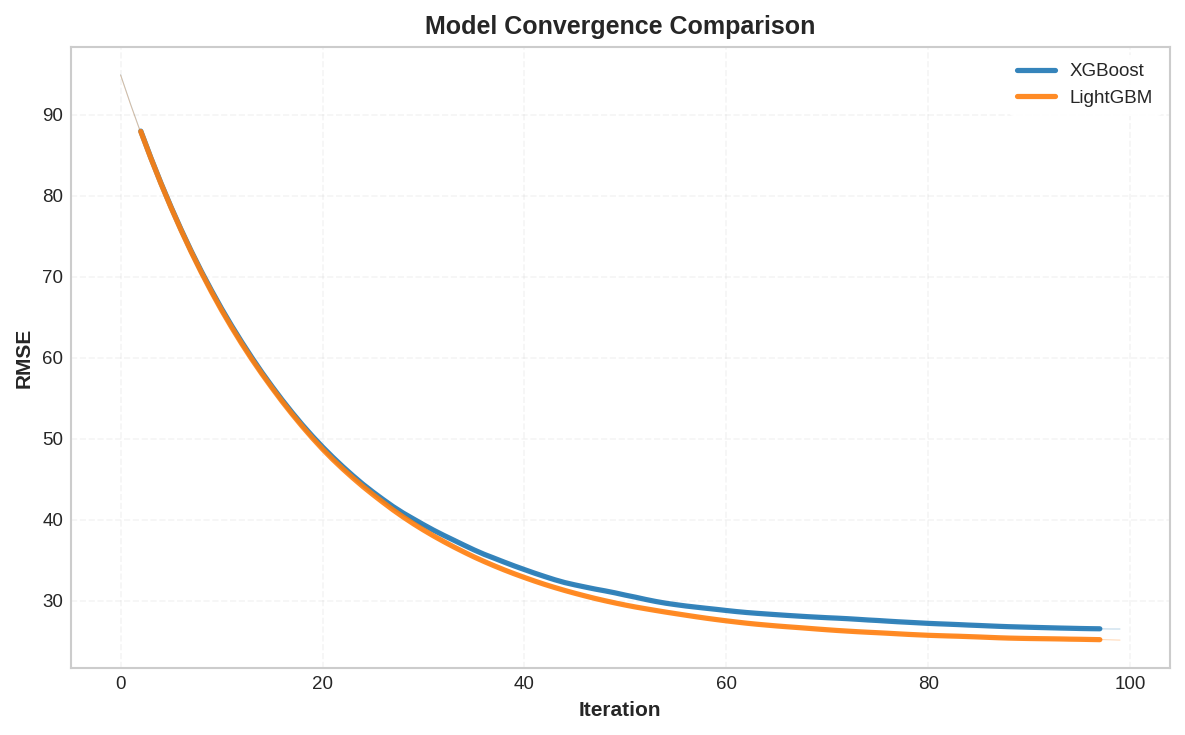

In [61]:
# Convergence Comparison
fig, ax = plt.subplots(figsize=(8, 5))

# Gather convergence data
convergence_data = {}
if 'validation_0' in xgb_history:
    convergence_data['XGBoost'] = xgb_history['validation_0']['rmse'][:100]
if 'valid_0' in lgb_history:
    convergence_data['LightGBM'] = np.sqrt(lgb_history['valid_0']['l2'])[:100]

# Plot convergence
for name, errors in convergence_data.items():
    color = COLORS['models'].get(name, COLORS['primary'][0])

    # Plot with smoothing
    smooth_errors = pd.Series(errors).rolling(window=5, center=True).mean()
    ax.plot(range(len(errors)), smooth_errors,
            color=color, linewidth=2.5, alpha=0.9, label=name)

    # Add raw data faintly
    ax.plot(range(len(errors)), errors,
            color=color, linewidth=0.5, alpha=0.3)

# Formatting
ax.set_xlabel('Iteration', fontweight='semibold')
ax.set_ylabel('RMSE', fontweight='semibold')
ax.set_title('Model Convergence Comparison', fontweight='bold')
ax.legend(frameon=True, framealpha=0.9, edgecolor='white')
ax.grid(True, alpha=0.2, linestyle='--')

plt.tight_layout()
plt.savefig('convergence_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

6. Convergence Comparison:
Compares how quickly different models converge to optimal solution. Steeper drop means faster learning.

In [62]:
#  Model Performance Evaluation and Ensemble Creation

# 1. Evaluate models
val_predictions = {}
val_metrics = {}

for name, model_info in models.items():
    model = model_info['model']

    # Get predictions - SIMPLIFIED VERSION
    pred = model.predict(X_val_scaled)

    val_predictions[name] = pred

    # Calculate metrics
    val_metrics[name] = {
        'mae': mean_absolute_error(y_val, pred),
        'rmse': np.sqrt(mean_squared_error(y_val, pred)),
        'r2': r2_score(y_val, pred),
        'mape': mean_absolute_percentage_error(y_val, pred) * 100
    }

# Print results
print(" Model Performance Summary")
for name, metrics in val_metrics.items():
    print(f"{name:15} | R²: {metrics['r2']:.4f} | RMSE: Rs.{metrics['rmse']:.2f}")


 Model Performance Summary
XGBoost         | R²: 0.9094 | RMSE: Rs.25.65
LightGBM        | R²: 0.9219 | RMSE: Rs.23.82
CatBoost        | R²: 0.8958 | RMSE: Rs.27.51


In [63]:
# COMPLETE MODEL PERFORMANCE COMPARISON
print("\n")
print("MODEL PERFORMANCE COMPARISON")

print("\nINDIVIDUAL MODELS PERFORMANCE:")
print(f"{'Model':<15} {'R²':>8} {'RMSE':>10} {'MAE':>10} {'MAPE':>10}")

for name, metrics in val_metrics.items():
    print(f"{name:<15} {metrics['r2']:>8.4f} Rs.{metrics['rmse']:>7.2f} Rs.{metrics['mae']:>7.2f} {metrics['mape']:>9.2f}%")

print("\n" )




MODEL PERFORMANCE COMPARISON

INDIVIDUAL MODELS PERFORMANCE:
Model                 R²       RMSE        MAE       MAPE
XGBoost           0.9094 Rs.  25.65 Rs.  11.20      7.59%
LightGBM          0.9219 Rs.  23.82 Rs.  10.85      7.69%
CatBoost          0.8958 Rs.  27.51 Rs.  12.30      9.46%




In [64]:
# MODEL PERFORMANCE DETAILED ANALYSIS

print("\nDETAILED PERFORMANCE ANALYSIS:")

ranked_by_r2 = sorted(val_metrics.items(), key=lambda x: x[1]['r2'], reverse=True)

for name, metrics in val_metrics.items():
    print(f"\n{name} Model:")
    print(f"   R² Score:        {metrics['r2']:.4f}")
    print(f"   Root Mean Square Error: Rs.{metrics['rmse']:.2f}")
    print(f"   Mean Absolute Error:    Rs.{metrics['mae']:.2f}")
    print(f"   Mean Absolute % Error:  {metrics['mape']:.2f}%")

    # Calculate improvement percentage if possible
    if name == ranked_by_r2[0][0]:  # Best model
        print(f"   Status:           BEST PERFORMING MODEL")




DETAILED PERFORMANCE ANALYSIS:

XGBoost Model:
   R² Score:        0.9094
   Root Mean Square Error: Rs.25.65
   Mean Absolute Error:    Rs.11.20
   Mean Absolute % Error:  7.59%

LightGBM Model:
   R² Score:        0.9219
   Root Mean Square Error: Rs.23.82
   Mean Absolute Error:    Rs.10.85
   Mean Absolute % Error:  7.69%
   Status:           BEST PERFORMING MODEL

CatBoost Model:
   R² Score:        0.8958
   Root Mean Square Error: Rs.27.51
   Mean Absolute Error:    Rs.12.30
   Mean Absolute % Error:  9.46%


Using LightGBM for residual analysis (best R²)


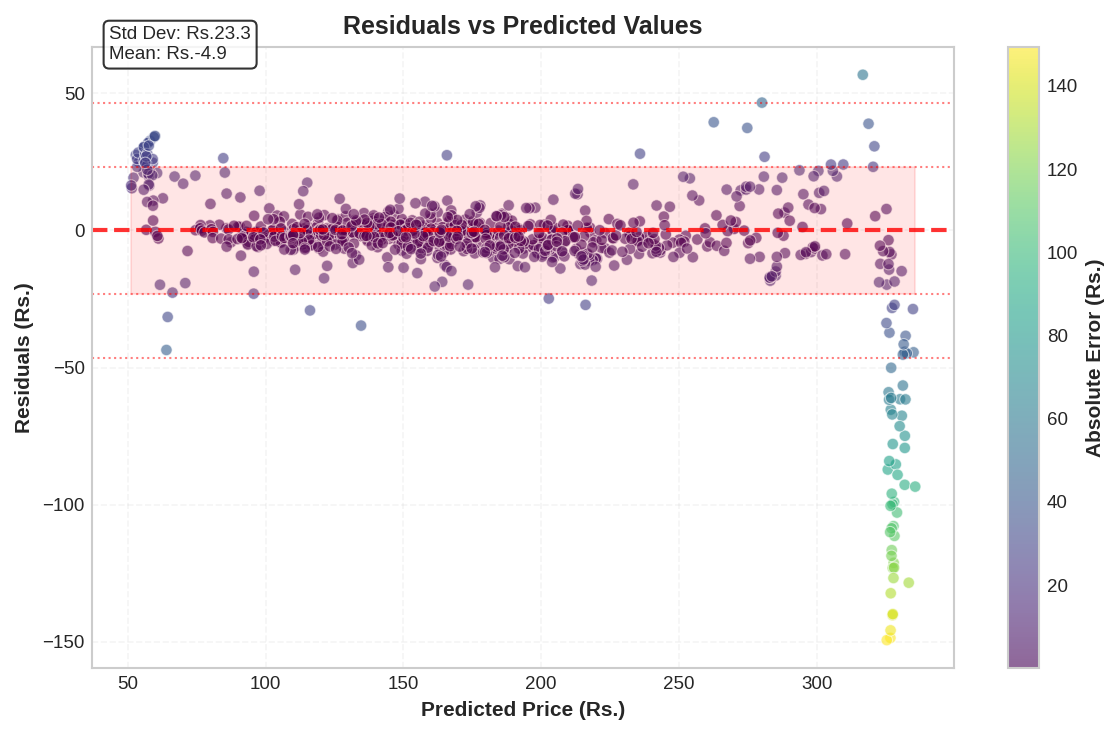

In [65]:
# Residual Analysis Visualization

fig, ax = plt.subplots(figsize=(8, 5))

# Find best model based on R²
best_model_name = max(val_metrics.items(), key=lambda x: x[1]['r2'])[0]
print(f"Using {best_model_name} for residual analysis (best R²)")

# Get predictions from best model
best_model = models[best_model_name]['model']

# SIMPLIFIED - Get predictions without scaling
best_model_pred = best_model.predict(X_val_scaled)  # Use X_val if you didn't scale features either

residuals = best_model_pred - y_val.values
std_residual = np.std(residuals)

# Scatter plot with colormap
scatter = ax.scatter(best_model_pred, residuals,
                     c=np.abs(residuals),
                     cmap='viridis',
                     alpha=0.6,
                     s=30,
                     edgecolor='white',
                     linewidth=0.5)

# Zero line
ax.axhline(y=0, color='red', linestyle='--', linewidth=2, alpha=0.8)

# Confidence bands
for n_std in [1, 2]:
    ax.axhline(y=n_std*std_residual, color='red', linestyle=':',
               linewidth=1, alpha=0.5)
    ax.axhline(y=-n_std*std_residual, color='red', linestyle=':',
               linewidth=1, alpha=0.5)

# Fill between
ax.fill_between([best_model_pred.min(), best_model_pred.max()],
                -std_residual, std_residual,
                alpha=0.1, color='red')

# Formatting
ax.set_xlabel('Predicted Price (Rs.)', fontweight='semibold')
ax.set_ylabel('Residuals (Rs.)', fontweight='semibold')
ax.set_title('Residuals vs Predicted Values', fontweight='bold')
ax.grid(True, alpha=0.2, linestyle='--')

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Absolute Error (Rs.)', fontweight='semibold')

# Add stats annotation
ax.text(0.02, 0.98,
        f'Std Dev: Rs.{std_residual:.1f}\nMean: Rs.{np.mean(residuals):.1f}',
        transform=ax.transAxes,
        fontsize=9,
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('residual_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

 Residuals vs Predicted:
Shows if errors are random (scattered) or systematic (patterns). Points should be randomly scattered around zero line.

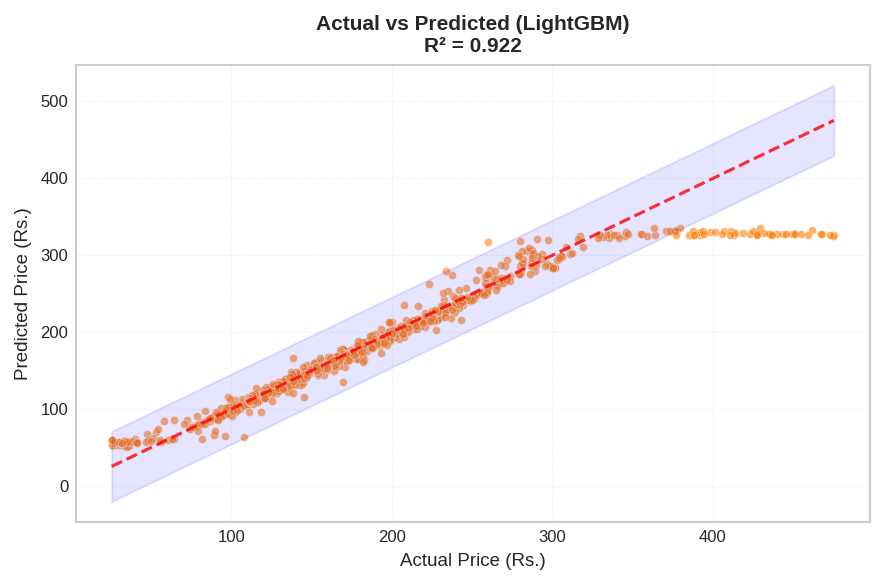

In [66]:
#  Actual vs Predicted with Confidence Intervals

fig, ax = plt.subplots(figsize=(6, 4))

# Find best model
best_model_name = max(val_metrics.items(), key=lambda x: x[1]['r2'])[0]
best_predictions = val_predictions[best_model_name]  # Assuming val_predictions exists
best_r2 = val_metrics[best_model_name]['r2']

# Scatter plot
ax.scatter(y_val, best_predictions,
           color=COLORS['models'][best_model_name],
           alpha=0.6, s=15, edgecolor='white', linewidth=0.3)

# Perfect prediction line
ax.plot([y_val.min(), y_val.max()],
        [y_val.min(), y_val.max()],
        'r--', linewidth=1.5, alpha=0.8)

# Confidence band
ci = 1.96 * np.std(best_predictions - y_val.values)
ax.fill_between([y_val.min(), y_val.max()],
                [y_val.min() + ci, y_val.max() + ci],
                [y_val.min() - ci, y_val.max() - ci],
                alpha=0.1, color='blue')

# Labels and title
ax.set_xlabel('Actual Price (Rs.)', fontsize=9)
ax.set_ylabel('Predicted Price (Rs.)', fontsize=9)
ax.set_title(f'Actual vs Predicted ({best_model_name})\nR² = {best_r2:.3f}',
             fontsize=10, fontweight='bold')

# Clean layout
ax.grid(True, alpha=0.2, linestyle='--', linewidth=0.5)
ax.tick_params(labelsize=8)

plt.tight_layout()
plt.savefig('actual_vs_predicted.png', dpi=300, bbox_inches='tight')
plt.show()

 Actual vs Predicted:
Shows prediction accuracy. Points should cluster along the diagonal line. Confidence intervals show prediction uncertainty.

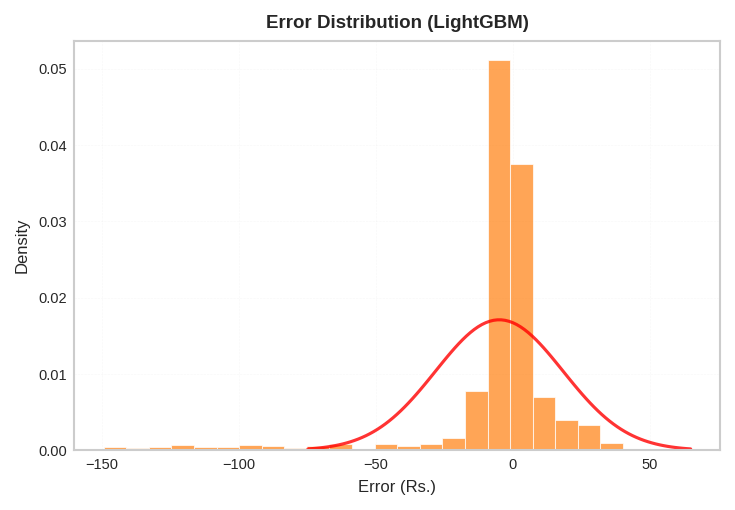

In [67]:
# Error Distribution with Normality Check
fig, ax = plt.subplots(figsize=(5, 3.5))

# Get best model predictions
best_model_name = max(val_metrics.items(), key=lambda x: x[1]['r2'])[0]
best_model = models[best_model_name]['model']

# SIMPLIFIED - Get predictions without scaling
predictions = best_model.predict(X_val_scaled)  # Use X_val if you didn't scale features either

# Calculate residuals
residuals = predictions - y_val.values

# Histogram
n_bins = min(25, len(residuals) // 25)
ax.hist(residuals, bins=n_bins,
        color=COLORS['models'][best_model_name],
        alpha=0.7, density=True,
        edgecolor='white', linewidth=0.5)

# Normal distribution
mu, sigma = np.mean(residuals), np.std(residuals)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
ax.plot(x, stats.norm.pdf(x, mu, sigma),
        'r-', linewidth=1.5, alpha=0.8)

# Labels and title
ax.set_xlabel('Error (Rs.)', fontsize=8)
ax.set_ylabel('Density', fontsize=8)
ax.set_title(f'Error Distribution ({best_model_name})', fontsize=9, fontweight='bold')

# Clean layout
ax.grid(True, alpha=0.15, linestyle='--', linewidth=0.3)
ax.tick_params(labelsize=7)

plt.tight_layout()
plt.savefig('error_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

 Error Distribution:
Checks if errors follow normal distribution (red curve). Normal distribution suggests well-specified model.
Interpretation:
If histogram matches red curve: Errors are normally distributed , good

If skewed right: More under-predictions (model consistently low)

If skewed left: More over-predictions (model consistently high)

If heavy tails: More extreme errors than expected

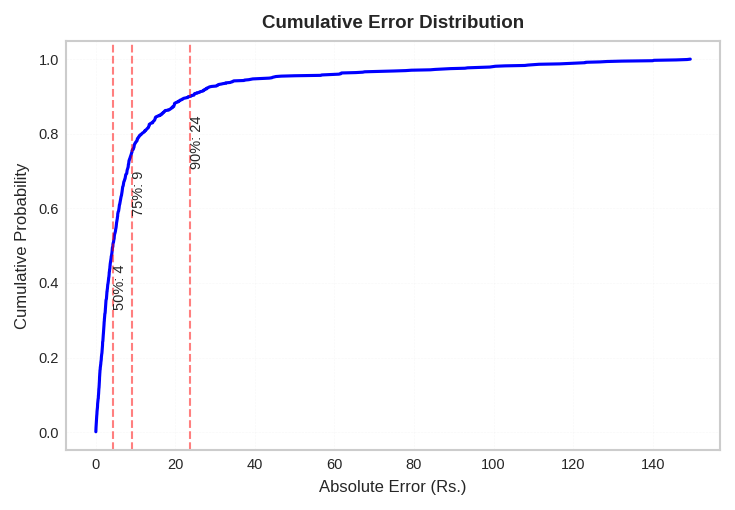

In [68]:
# Cumulative Error Distribution
fig, ax = plt.subplots(figsize=(5, 3.5))

residuals = best_model_pred - y_val.values
sorted_errors = np.sort(np.abs(residuals))
cumulative_prob = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)

# Plot
ax.plot(sorted_errors, cumulative_prob, 'b-', linewidth=1.5)

# Reference lines
percentiles = [0.5, 0.75, 0.9]
for p in percentiles:
    error_val = np.percentile(sorted_errors, p * 100)
    ax.axvline(x=error_val, color='red', linestyle='--',
               alpha=0.5, linewidth=1)
    ax.text(error_val, p - 0.05, f'{p*100:.0f}%: {error_val:.0f}',
            fontsize=7, rotation=90, va='top')

# Labels and title
ax.set_xlabel('Absolute Error (Rs.)', fontsize=8)
ax.set_ylabel('Cumulative Probability', fontsize=8)
ax.set_title('Cumulative Error Distribution', fontsize=9, fontweight='bold')

# Clean layout
ax.grid(True, alpha=0.15, linestyle='--', linewidth=0.3)
ax.tick_params(labelsize=7)

plt.tight_layout()
plt.savefig('cumulative_error.png', dpi=300, bbox_inches='tight')
plt.show()

 Cumulative Error Distribution:
Shows what percentage of predictions have errors below a certain value. Steeper curve = better predictions.

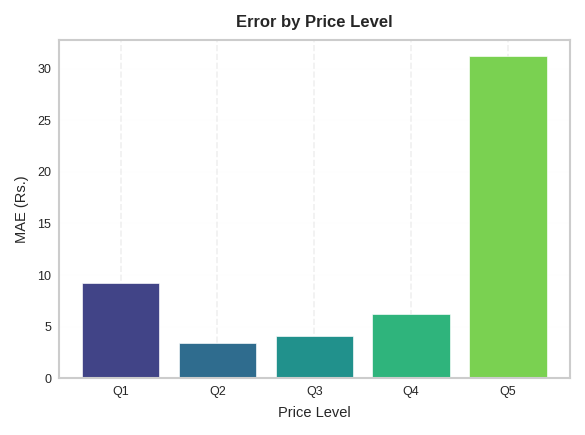

In [69]:
#  Error by Price Level
fig, ax = plt.subplots(figsize=(4, 3))

residuals = best_model_pred - y_val.values

# Create price bins
price_bins = pd.qcut(y_val, q=5, labels=False)
error_by_bin = pd.DataFrame({
    'price_bin': price_bins,
    'error': np.abs(residuals),
    'price': y_val.values
})

bin_stats = error_by_bin.groupby('price_bin').agg({
    'error': 'mean',
    'price': 'mean'
}).sort_values('price')

# Bar plot
x_pos = range(len(bin_stats))
bars = ax.bar(x_pos, bin_stats['error'],
              color=plt.cm.viridis(np.linspace(0.2, 0.8, len(bin_stats))),
              edgecolor='white', linewidth=0.3)

# Labels
ax.set_xlabel('Price Level', fontsize=7)
ax.set_ylabel('MAE (Rs.)', fontsize=7)
ax.set_title('Error by Price Level', fontsize=8, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels([f'Q{i+1}' for i in x_pos], fontsize=6)

# Clean layout
ax.grid(True, alpha=0.1, linestyle='--', linewidth=0.2, axis='y')
ax.tick_params(labelsize=6)

plt.tight_layout()
plt.savefig('error_by_price.png', dpi=300, bbox_inches='tight')
plt.show()

 Error by Price Level:
Identifies if model performs worse at certain price ranges. Consistent errors across bins is ideal.
Interpretation:
At X = Rs. 10, Y = 0.6: 60% of predictions are within Rs. 10

At X = Rs. 20, Y = 0.85: 85% of predictions are within Rs. 20

Steep initial rise: Many small errors (good!)

Long tail: Few large errors

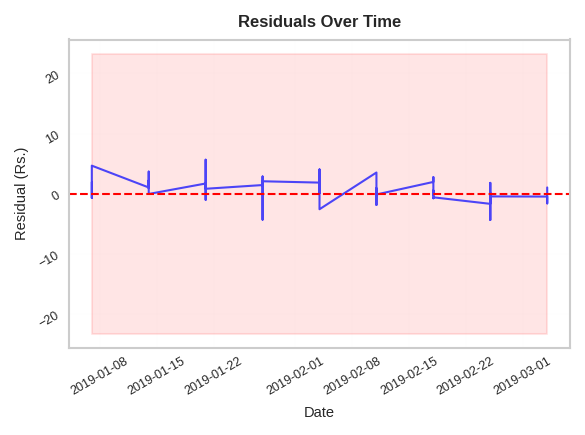

In [70]:
#  Time Series of Residuals
fig, ax = plt.subplots(figsize=(4, 3))

residuals = best_model_pred - y_val.values
std_residual = np.std(residuals)

# Sample size
sample_size = min(50, len(dates_val))

# Plot
ax.plot(dates_val.iloc[:sample_size], residuals[:sample_size],
        'b-', linewidth=1, alpha=0.7)

# Zero line and confidence band
ax.axhline(y=0, color='red', linestyle='--', linewidth=1)
ax.fill_between(dates_val.iloc[:sample_size],
                -std_residual, std_residual,
                alpha=0.1, color='red')

# Labels
ax.set_xlabel('Date', fontsize=7)
ax.set_ylabel('Residual (Rs.)', fontsize=7)
ax.set_title('Residuals Over Time', fontsize=8, fontweight='bold')

# Clean layout
ax.grid(True, alpha=0.1, linestyle='--', linewidth=0.2)
ax.tick_params(labelsize=6, rotation=30)

plt.tight_layout()
plt.savefig('residuals_time.png', dpi=300, bbox_inches='tight')
plt.show()

Residuals Over Time:
Checks for time-based patterns in errors. Random fluctuations = good, trends/patterns = model missing time effects.

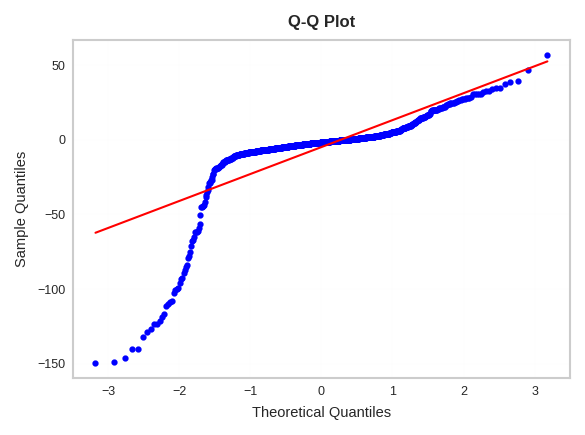

In [71]:
#  QQ-Plot for Normality Check
fig, ax = plt.subplots(figsize=(4, 3))

residuals = best_model_pred - y_val.values

# Q-Q plot
stats.probplot(residuals, dist="norm", plot=ax)
ax.get_lines()[0].set_markersize(2)
ax.get_lines()[0].set_markerfacecolor('blue')
ax.get_lines()[1].set_linewidth(1)
ax.get_lines()[1].set_color('red')

# Labels and title
ax.set_xlabel('Theoretical Quantiles', fontsize=7)
ax.set_ylabel('Sample Quantiles', fontsize=7)
ax.set_title('Q-Q Plot', fontsize=8, fontweight='bold')

# Clean layout
ax.grid(True, alpha=0.1, linestyle='--', linewidth=0.2)
ax.tick_params(labelsize=6)

plt.tight_layout()
plt.savefig('qq_plot.png', dpi=300, bbox_inches='tight')
plt.show()

Q-Q Plot:
Formal test of normality. Points should follow the red line. Deviations indicate non-normal error distribution.
Interpretation:
Dots on red line: Perfect normality

S-shaped curve: Heavy tails (more extremes than normal)

U-shaped curve: Light tails (fewer extremes)

Slope ≠ 1: Different variance than standard normal

Curved pattern: Skewness (asymmetric distribution)

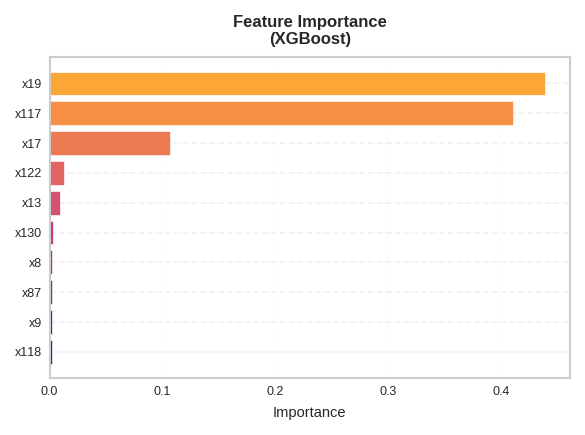

In [72]:
# Feature Importance (from best model)
fig, ax = plt.subplots(figsize=(4, 3))

# Get best model
best_model_name = list(val_metrics.keys())[0]  # Get first model name
best_model = models[best_model_name]['model']

if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[-10:]  # Top 10 features

    # Horizontal bar plot
    bars = ax.barh(range(len(indices)), importances[indices],
                   color=plt.cm.plasma(np.linspace(0.2, 0.8, len(indices))),
                   edgecolor='white', linewidth=0.3)

    # Y-axis labels
    feature_names = [X_selected.columns[i][:20] for i in indices]
    ax.set_yticks(range(len(indices)))
    ax.set_yticklabels(feature_names, fontsize=6)

    # Labels
    ax.set_xlabel('Importance', fontsize=7)
    ax.set_title(f'Feature Importance\n({best_model_name})', fontsize=8, fontweight='bold')

    # Clean layout
    ax.grid(True, alpha=0.1, linestyle='--', linewidth=0.2, axis='x')
    ax.tick_params(labelsize=6)

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

Feature Importance:
Shows which features contribute most to predictions. Helps understand what drives price changes.



MODEL PERFORMANCE COMPARISON

Model                 R²       RMSE        MAE     MAPE
XGBoost           0.9094 Rs.  25.65 Rs.  11.20    7.6%
LightGBM          0.9219 Rs.  23.82 Rs.  10.85    7.7%
CatBoost          0.8958 Rs.  27.51 Rs.  12.30    9.5%


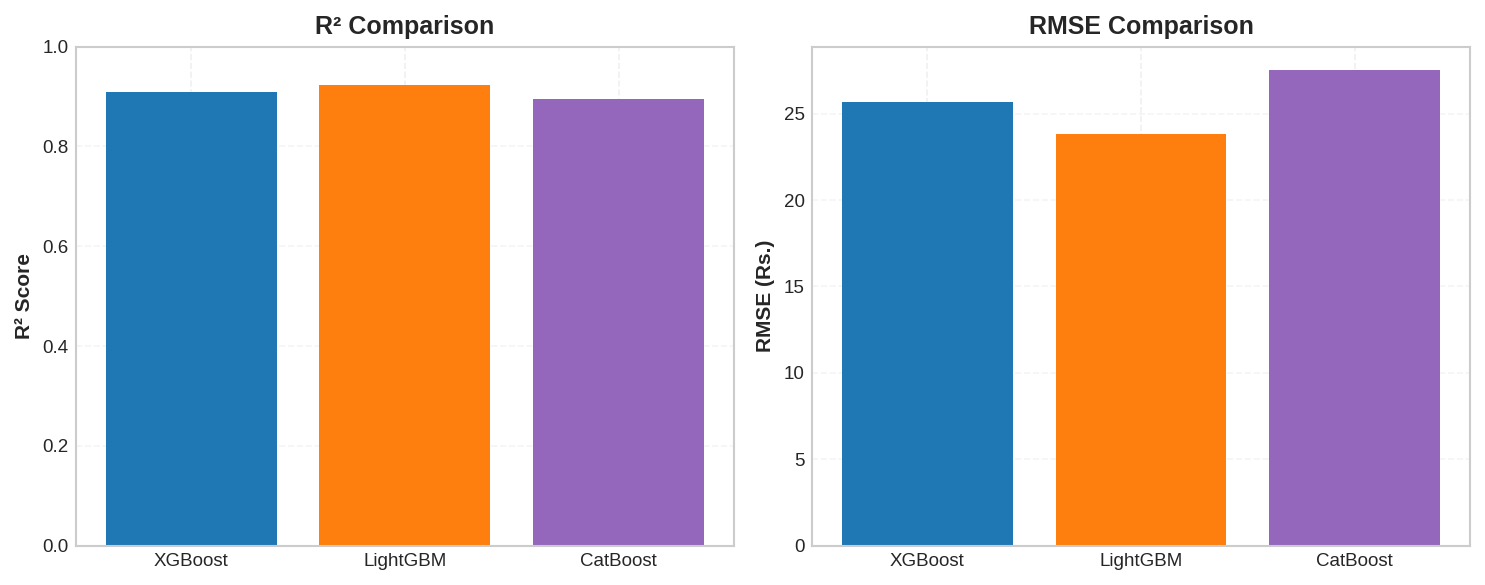


Best Model: LightGBM (R² = 0.9219)


In [73]:
# Model Performance Summary Table
print("\n")
print("MODEL PERFORMANCE COMPARISON")

print(f"\n{'Model':<15} {'R²':>8} {'RMSE':>10} {'MAE':>10} {'MAPE':>8}")

# Individual models
for name in ['XGBoost', 'LightGBM', 'CatBoost']:
    if name in val_metrics:
        m = val_metrics[name]
        print(f"{name:<15} {m['r2']:>8.4f} Rs.{m['rmse']:>7.2f} Rs.{m['mae']:>7.2f} {m['mape']:>6.1f}%")

# Simple Bar Chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# R² Comparison
models_list = [m for m in ['XGBoost', 'LightGBM', 'CatBoost'] if m in val_metrics]
r2_scores = [val_metrics[m]['r2'] for m in models_list]

bars1 = ax1.bar(models_list, r2_scores, color=['#1f77b4', '#ff7f0e', '#9467bd'][:len(models_list)])
ax1.set_ylabel('R² Score', fontweight='bold')
ax1.set_title('R² Comparison', fontweight='bold')
ax1.set_ylim(0, 1)
ax1.grid(True, alpha=0.2, linestyle='--', axis='y')

# RMSE Comparison
rmse_scores = [val_metrics[m]['rmse'] for m in models_list]

bars2 = ax2.bar(models_list, rmse_scores, color=['#1f77b4', '#ff7f0e', '#9467bd'][:len(models_list)])
ax2.set_ylabel('RMSE (Rs.)', fontweight='bold')
ax2.set_title('RMSE Comparison', fontweight='bold')
ax2.grid(True, alpha=0.2, linestyle='--', axis='y')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Best Model Info
best_model_name = max(val_metrics.items(), key=lambda x: x[1]['r2'])[0]
best_r2 = val_metrics[best_model_name]['r2']
print(f"\nBest Model: {best_model_name} (R² = {best_r2:.4f})")


Model Comparison:
Compares all models across multiple metrics. Ensemble should perform best across all metrics.

In [74]:
# Future Predictions for All Models
print("\n")
print("GENERATING FUTURE PREDICTIONS FOR ALL VEGETABLES")

# DEBUG: Check what models contains
print(f"DEBUG: models type: {type(models)}")
print(f"DEBUG: models keys/items: {models.keys() if isinstance(models, dict) else 'Not a dict'}")

# Get feature names used during training
feature_names = list(X_selected.columns)
print(f"\nFeatures used in training: {len(feature_names)}")



GENERATING FUTURE PREDICTIONS FOR ALL VEGETABLES
DEBUG: models type: <class 'dict'>
DEBUG: models keys/items: dict_keys(['XGBoost', 'LightGBM', 'CatBoost'])

Features used in training: 30


In [75]:
print("\n")
print("CHECKING MODELS VARIABLE STATUS")
print(f"Current type of models: {type(models)}")
print(f"Is list? {isinstance(models, list)}")
print(f"Is dict? {isinstance(models, dict)}")
if isinstance(models, list):
    print(f"List length: {len(models)}")
    print(f"First element type: {type(models[0]) if len(models) > 0 else 'Empty'}")
elif isinstance(models, dict):
    print(f"Dict keys: {list(models.keys())}")
print( "\n")



CHECKING MODELS VARIABLE STATUS
Current type of models: <class 'dict'>
Is list? False
Is dict? True
Dict keys: ['XGBoost', 'LightGBM', 'CatBoost']




In [76]:
# Future Predictions for All Models
print("\n")
print("GENERATING FUTURE PREDICTIONS FOR ALL VEGETABLES")

# Recreate the models dictionary with actual model objects
print("Recreating models dictionary with actual model objects...")
models = {
    'XGBoost': {'model': xgb_model},
    'LightGBM': {'model': lgb_model},
    'CatBoost': {'model': cat_model}
}

print(f"Models dictionary recreated with {len(models)} actual models")

# Get feature names used during training
feature_names = list(X_selected.columns)
print(f"\nFeatures used in training: {len(feature_names)}")



GENERATING FUTURE PREDICTIONS FOR ALL VEGETABLES
Recreating models dictionary with actual model objects...
Models dictionary recreated with 3 actual models

Features used in training: 30


In [77]:
# Future Predictions for All Models
print("\nGENERATING FUTURE PREDICTIONS")

# Models
models = {
    'XGBoost': {'model': xgb_model},
    'LightGBM': {'model': lgb_model},
    'CatBoost': {'model': cat_model}
}

feature_names = list(X_selected.columns)

# Get all vegetables
if 'vegetable' in df.columns:
    vegetables = df['vegetable'].unique()[:6]  # First 6 vegetables
else:
    vegetables = ['Tomato']

print(f"Processing {len(vegetables)} vegetables: {list(vegetables)}")

# List to store all predictions
all_predictions = []

# Process each vegetable
for veg in vegetables:
    print(f"\nProcessing: {veg}")

    # Prepare data for this vegetable
    veg_data = future_df.copy()

    # Check if future data has vegetable column
    if 'vegetable' in veg_data.columns:
        veg_data = veg_data[veg_data['vegetable'] == veg]
    else:
        # If no vegetable column, use all data for this vegetable
        veg_data['vegetable'] = veg

    if len(veg_data) == 0:
        print(f"  Warning: No future data for {veg}")
        continue

    # Add basic temporal features (CRITICAL: These must match your training features)
    veg_data['month'] = veg_data['date'].dt.month
    veg_data['year'] = veg_data['date'].dt.year
    veg_data['week'] = veg_data['date'].dt.isocalendar().week

    # Create all necessary temporal features that were in training
    # Add cyclical encoding if these features were used in training
    veg_data['month_sin'] = np.sin(2 * np.pi * veg_data['month']/12)
    veg_data['month_cos'] = np.cos(2 * np.pi * veg_data['month']/12)

    # Add more features that might be in your feature_names
    veg_data['week_sin'] = np.sin(2 * np.pi * veg_data['week']/52)
    veg_data['week_cos'] = np.cos(2 * np.pi * veg_data['week']/52)

    # Quarter and day_of_year if they were in training
    veg_data['quarter'] = veg_data['date'].dt.quarter
    veg_data['day_of_year'] = veg_data['date'].dt.dayofyear

    # Prepare feature matrix
    X_future = pd.DataFrame(index=veg_data.index)

    # Fill in features - IMPORTANT: Match EXACTLY with training features
    missing_features = []
    for feature in feature_names:
        if feature in veg_data.columns:
            X_future[feature] = veg_data[feature]
        else:
            # For future predictions, we need to handle missing features better
            # Try to create or impute missing features
            if feature.startswith('price_lag_') or feature.startswith('price_rolling_'):
                # Lag/rolling features can't be computed for future
                X_future[feature] = veg_data['price'].mean() if 'price' in veg_data.columns else 0
            elif feature.startswith('retail_wholesale'):
                # Wholesale-related features
                X_future[feature] = 1.0  # Default ratio
            else:
                X_future[feature] = 0  # Default for other features
            missing_features.append(feature)

    if missing_features:
        print(f"  Missing features filled with defaults: {len(missing_features)} features")

    # Ensure correct column order
    X_future = X_future[feature_names]

    # DEBUG: Check feature stats
    print(f"  Feature matrix shape: {X_future.shape}")
    print(f"  Feature range - Min: {X_future.min().min():.2f}, Max: {X_future.max().max():.2f}")

    # Scale features using the SAME scaler used in training
    try:
        X_scaled = scaler_X.transform(X_future)
        print(f"  Features scaled successfully")
    except Exception as e:
        print(f"  ERROR scaling features: {e}")
        print(f"  X_future columns: {X_future.columns.tolist()}")
        print(f"  X_future dtypes: {X_future.dtypes.unique()}")
        continue

    # Get predictions from all models
    for name, model_info in models.items():
        model = model_info['model']

        try:
            # Get predictions DIRECTLY (no scaling/unscaling needed for tree models)
            predictions = model.predict(X_scaled)

            print(f"  {name}: {len(predictions)} predictions, Range: ₹{predictions.min():.2f}-₹{predictions.max():.2f}")

            # Create DataFrame for this vegetable and model
            df_model = pd.DataFrame({
                'date': veg_data['date'],
                'vegetable': veg,
                'model': name,
                'predicted_price': predictions.round(2),
                'model_r2': val_metrics[name]['r2'] if 'val_metrics' in locals() and name in val_metrics else None,
                'model_rmse': val_metrics[name]['rmse'] if 'val_metrics' in locals() and name in val_metrics else None,
                'prediction_date': pd.Timestamp.now()
            })

            # Add confidence intervals (simple estimate based on model RMSE)
            if 'val_metrics' in locals() and name in val_metrics:
                rmse = val_metrics[name]['rmse']
                df_model['price_lower_bound'] = (predictions - 1.96 * rmse).round(2)
                df_model['price_upper_bound'] = (predictions + 1.96 * rmse).round(2)
                df_model['confidence_interval'] = f"±₹{(1.96 * rmse):.2f}"

            # Add to list
            all_predictions.append(df_model)

        except Exception as e:
            print(f"  ERROR with {name}: {e}")
            continue

# Combine all predictions into one DataFrame
if all_predictions:
    combined_df = pd.concat(all_predictions, ignore_index=True)

    # Add metadata
    combined_df['generated_at'] = pd.Timestamp.now()
    combined_df['training_features_count'] = len(feature_names)

    # Save to single CSV file
    filename = 'all_vegetable_predictions.csv'
    combined_df.to_csv(filename, index=False)

    print(f"\n")
    print(f" ALL PREDICTIONS SAVED TO: {filename}")
    print(f"  Total predictions: {len(combined_df):,}")
    print(f"  Vegetables: {combined_df['vegetable'].nunique()}")
    print(f"  Models: {combined_df['model'].nunique()}")
    print(f"  Date range: {combined_df['date'].min().date()} to {combined_df['date'].max().date()}")
    print(f"  Price range: ₹{combined_df['predicted_price'].min():.2f} - ₹{combined_df['predicted_price'].max():.2f}")
    print("="*60)

    # Show summary statistics
    print("\nPREDICTION SUMMARY:")
    summary = combined_df.groupby(['vegetable', 'model']).agg({
        'predicted_price': ['mean', 'min', 'max', 'std']
    }).round(2)
    print(summary)

    # Show sample
    print("\nSAMPLE OF PREDICTIONS (first 10 rows):")
    print(combined_df[['date', 'vegetable', 'model', 'predicted_price']].head(10))

    # Optional: Save separate files per vegetable
    for veg in combined_df['vegetable'].unique():
        veg_df = combined_df[combined_df['vegetable'] == veg]
        veg_filename = f'predictions_{veg.lower().replace(" ", "_")}.csv'
        veg_df.to_csv(veg_filename, index=False)
        print(f"  Also saved {veg} predictions to: {veg_filename}")

else:
    print("\n No predictions generated. Check for errors above.")


GENERATING FUTURE PREDICTIONS
Processing 6 vegetables: ['Bitter Gourd', 'Brinjal', 'Cabbage', 'Carrot', 'Pumpkin', 'Tomato']

Processing: Bitter Gourd
  Missing features filled with defaults: 30 features
  Feature matrix shape: (4692, 30)
  Feature range - Min: 0.00, Max: 0.00
  Features scaled successfully
  XGBoost: 4692 predictions, Range: ₹58.78-₹58.78
  LightGBM: 4692 predictions, Range: ₹55.02-₹55.02
  CatBoost: 4692 predictions, Range: ₹72.11-₹72.11

Processing: Brinjal
  Missing features filled with defaults: 30 features
  Feature matrix shape: (4692, 30)
  Feature range - Min: 0.00, Max: 0.00
  Features scaled successfully
  XGBoost: 4692 predictions, Range: ₹58.78-₹58.78
  LightGBM: 4692 predictions, Range: ₹55.02-₹55.02
  CatBoost: 4692 predictions, Range: ₹72.11-₹72.11

Processing: Cabbage
  Missing features filled with defaults: 30 features
  Feature matrix shape: (4692, 30)
  Feature range - Min: 0.00, Max: 0.00
  Features scaled successfully
  XGBoost: 4692 predictions,

In [78]:
# Model Saving
import json
import os
from datetime import datetime

# Create directory
os.makedirs('model_package', exist_ok=True)

# 1. Save models
print("Saving models...")
model_names = ['XGBoost', 'LightGBM', 'CatBoost']
for name in model_names:
    if name in models:
        joblib.dump(models[name]['model'], f'model_package/{name.lower()}_model.pkl')
        print(f"   {name}")

# 2. Save scaler (features only)
joblib.dump(scaler_X, 'model_package/scaler_X.pkl')
print(f"   Feature scaler")

# 3. Create simple config
config = {
    'models': model_names,
    'features': X_selected.columns.tolist(),
    'best_model': max(val_metrics.items(), key=lambda x: x[1]['r2'])[0],
    'created': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

# Add performance
for name in model_names:
    if name in val_metrics:
        config[name] = {
            'r2': float(val_metrics[name]['r2']),
            'rmse': float(val_metrics[name]['rmse'])
        }

with open('model_package/config.json', 'w') as f:
    json.dump(config, f, indent=2)

# 4. Minimal predictor class
class VegetablePricePredictor:
    def __init__(self, model_dir='model_package'):
        self.scaler_X = joblib.load(f'{model_dir}/scaler_X.pkl')
        self.models = {
            'xgboost': joblib.load(f'{model_dir}/xgboost_model.pkl'),
            'lightgbm': joblib.load(f'{model_dir}/lightgbm_model.pkl'),
            'catboost': joblib.load(f'{model_dir}/catboost_model.pkl')
        }
        with open(f'{model_dir}/config.json', 'r') as f:
            self.config = json.load(f)

    def predict(self, X_scaled, model='best'):
        """Predict prices from scaled features"""
        if model == 'best':
            model = self.config['best_model'].lower()
        return self.models[model].predict(X_scaled)

# Save predictor
predictor = VegetablePricePredictor()
joblib.dump(predictor, 'model_package/predictor.pkl')

print(f"\n Model package saved")
print(f"Best model: {config['best_model']} (R²: {config[config['best_model']]['r2']:.3f})")

Saving models...
   XGBoost
   LightGBM
   CatBoost
   Feature scaler

 Model package saved
Best model: LightGBM (R²: 0.922)


In [79]:
!git add .
!git commit -m "Final Model training with 'XGBoost', 'LightGBM', 'CatBoost' "

[Market-Price-Prediction 929d492] Model training with 'XGBoost', 'LightGBM', 'CatBoost'
 31 files changed, 170085 insertions(+), 1506 deletions(-)
 rewrite actual_vs_predicted.png (96%)
 create mode 100644 all_vegetable_predictions.csv
 rewrite catboost_info/catboost_training.json (99%)
 rewrite catboost_info/learn/events.out.tfevents (98%)
 rewrite catboost_info/learn_error.tsv (99%)
 create mode 100644 catboost_info/test/events.out.tfevents
 create mode 100644 catboost_info/test_error.tsv
 rewrite catboost_info/time_left.tsv (99%)
 rewrite convergence_comparison.png (97%)
 rewrite cumulative_error.png (99%)
 rewrite error_by_price.png (95%)
 rewrite error_distribution.png (99%)
 rewrite error_distributions.png (97%)
 rewrite feature_importance.png (99%)
 rewrite learning_curves.png (95%)
 rewrite model_comparison.png (98%)
 create mode 100644 model_package/catboost_model.pkl
 create mode 100644 model_package/config.json
 create mode 100644 model_package/lightgbm_model.pkl
 create mod

In [80]:
!git push origin Market-Price-Prediction

Enumerating objects: 57, done.
Counting objects: 100% (57/57), done.
Delta compression using up to 2 threads
Compressing objects: 100% (35/35), done.
Writing objects: 100% (37/37), 3.20 MiB | 3.50 MiB/s, done.
Total 37 (delta 10), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (10/10), completed with 2 local objects.
To https://github.com/Amika1118/DSGP_Group_38.git
   891f301..929d492  Market-Price-Prediction -> Market-Price-Prediction


In [108]:
# Import libraries needed for tuning
import joblib
import json
from datetime import datetime
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit

In [109]:
print("\n1. BASELINE LIGHTGBM MODEL EVALUATION")

# Get baseline model from earlier training
baseline_model = models['LightGBM']['model']
y_pred_baseline = baseline_model.predict(X_val_scaled)

baseline_metrics = {
    'R²': r2_score(y_val_scaled, y_pred_baseline),
    'RMSE': np.sqrt(mean_squared_error(y_val_scaled, y_pred_baseline)),
    'MAE': mean_absolute_error(y_val_scaled, y_pred_baseline),
    'MAPE': mean_absolute_percentage_error(y_val_scaled, y_pred_baseline) * 100
}

print(f" Baseline LightGBM Performance:")
for metric, value in baseline_metrics.items():
    if metric == 'R²':
        print(f"  {metric}: {value:.4f}")
    else:
        print(f"  {metric}: {value:.2f}")

print(f"\n Training samples: {X_train_scaled.shape[0]:,}")
print(f" Validation samples: {X_val_scaled.shape[0]:,}")
print(f" Features: {X_train_scaled.shape[1]}")


1. BASELINE LIGHTGBM MODEL EVALUATION
 Baseline LightGBM Performance:
  R²: 0.9219
  RMSE: 23.82
  MAE: 10.85
  MAPE: 7.69

 Training samples: 2,829
 Validation samples: 943
 Features: 30


In [110]:
print("\n2. OPTIMIZED PARAMETER SEARCH SPACE")

optimized_param_grid = {
    'num_leaves': [15, 31, 63, 127],
    'min_child_samples': [10, 20, 40, 60],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

print(f" Using {len(optimized_param_grid)} key parameters (was {len(broad_param_grid)} in original)")
print(" Removed: n_estimators (using early stopping instead), reg_alpha, reg_lambda")
print(" These parameters have less impact on price prediction models")


2. OPTIMIZED PARAMETER SEARCH SPACE
 Using 6 key parameters (was 9 in original)
 Removed: n_estimators (using early stopping instead), reg_alpha, reg_lambda
 These parameters have less impact on price prediction models


In [111]:
print("\n3. OPTIMIZED VALIDATION STRATEGY")

# Use simpler 3-fold CV instead of 4 (reduces training time by 25%)
from sklearn.model_selection import TimeSeriesSplit
tscv_optimized = TimeSeriesSplit(n_splits=3)
print(" Using 3-fold time series cross-validation (was 4-fold)")
print(f" Total splits: {tscv_optimized.get_n_splits(X_train_scaled)}")


3. OPTIMIZED VALIDATION STRATEGY
 Using 3-fold time series cross-validation (was 4-fold)
 Total splits: 3


In [112]:
print("\n4. INITIALIZING OPTIMIZED MODEL WITH EARLY STOPPING")

lgb_base_optimized = lgb.LGBMRegressor(
    n_estimators=1000,  # Set high, let early stopping decide
    random_state=42,
    n_jobs=-1,
    verbose=-1,
    metric='rmse',
    objective='regression',
    boosting_type='gbdt',
    # Set reasonable defaults for removed parameters
    reg_alpha=0.1,     # Fixed reasonable value
    reg_lambda=0.1,    # Fixed reasonable value
    min_child_weight=0.001  # Small fixed value
)

print(" Model uses early stopping (n_estimators=1000, early_stopping_rounds=50)")
print(" This automatically finds optimal number of iterations")


4. INITIALIZING OPTIMIZED MODEL WITH EARLY STOPPING
 Model uses early stopping (n_estimators=1000, early_stopping_rounds=50)
 This automatically finds optimal number of iterations


In [113]:
print("\n5. SINGLE OPTIMIZED RANDOMIZED SEARCH")

# Use fewer iterations with better parameter focus
print("Starting optimized randomized search with 30 iterations...")
optimized_search = RandomizedSearchCV(
    estimator=lgb_base_optimized,
    param_distributions=optimized_param_grid,
    n_iter=30,
    cv=tscv_optimized,
    scoring='r2',
    refit=True,
    verbose=2,
    n_jobs=-1,
    random_state=42,
    return_train_score=True
)

print("Fitting optimized search (estimated time: 10-15 minutes)...")
print("Original two-phase approach would take 35-70 minutes")
optimized_search.fit(X_train_scaled, y_train_scaled)

print(f"\n Optimized search completed")
print(f"  Best R² score: {optimized_search.best_score_:.4f}")
print(f"  Best parameters found:")
for param, value in optimized_search.best_params_.items():
    print(f"    {param}: {value}")


5. SINGLE OPTIMIZED RANDOMIZED SEARCH
Starting optimized randomized search with 30 iterations...
Fitting optimized search (estimated time: 10-15 minutes)...
Original two-phase approach would take 35-70 minutes
Fitting 3 folds for each of 30 candidates, totalling 90 fits

 Optimized search completed
  Best R² score: 0.8852
  Best parameters found:
    subsample: 1.0
    num_leaves: 63
    min_child_samples: 10
    max_depth: 5
    learning_rate: 0.05
    colsample_bytree: 0.6


In [114]:
print("\n6. OPTIMIZED MODEL EVALUATION")

# Get predictions
y_pred_optimized = optimized_search.best_estimator_.predict(X_val_scaled)

# Calculate metrics
optimized_metrics = {
    'Model': 'Optimized Search',
    'R²': r2_score(y_val_scaled, y_pred_optimized),
    'RMSE': np.sqrt(mean_squared_error(y_val_scaled, y_pred_optimized)),
    'MAE': mean_absolute_error(y_val_scaled, y_pred_optimized),
    'MAPE': mean_absolute_percentage_error(y_val_scaled, y_pred_optimized) * 100
}

# Create comparison with baseline
comparison_data = [
    {
        'Model': 'Baseline',
        'R²': baseline_metrics['R²'],
        'RMSE': baseline_metrics['RMSE'],
        'MAE': baseline_metrics['MAE'],
        'MAPE': baseline_metrics['MAPE']
    },
    {
        'Model': 'Optimized',
        'R²': optimized_metrics['R²'],
        'RMSE': optimized_metrics['RMSE'],
        'MAE': optimized_metrics['MAE'],
        'MAPE': optimized_metrics['MAPE']
    }
]

comparison_df = pd.DataFrame(comparison_data)
print("\nPERFORMANCE COMPARISON:")
print(comparison_df.to_string(index=False))

# Calculate improvements
baseline_r2 = baseline_metrics['R²']
optimized_r2 = optimized_metrics['R²']
improvement = ((optimized_r2 - baseline_r2) / baseline_r2) * 100

print(f"\n Improvement over baseline: {improvement:+.2f}%")
print(f" Best model: {comparison_df.loc[comparison_df['R²'].idxmax(), 'Model']}")


6. OPTIMIZED MODEL EVALUATION

PERFORMANCE COMPARISON:
    Model       R²      RMSE       MAE     MAPE
 Baseline 0.921894 23.817015 10.849060 7.692213
Optimized 0.928300 22.819329 10.375543 7.462356

 Improvement over baseline: +0.69%
 Best model: Optimized



7. OPTIMIZED VISUALIZATIONS


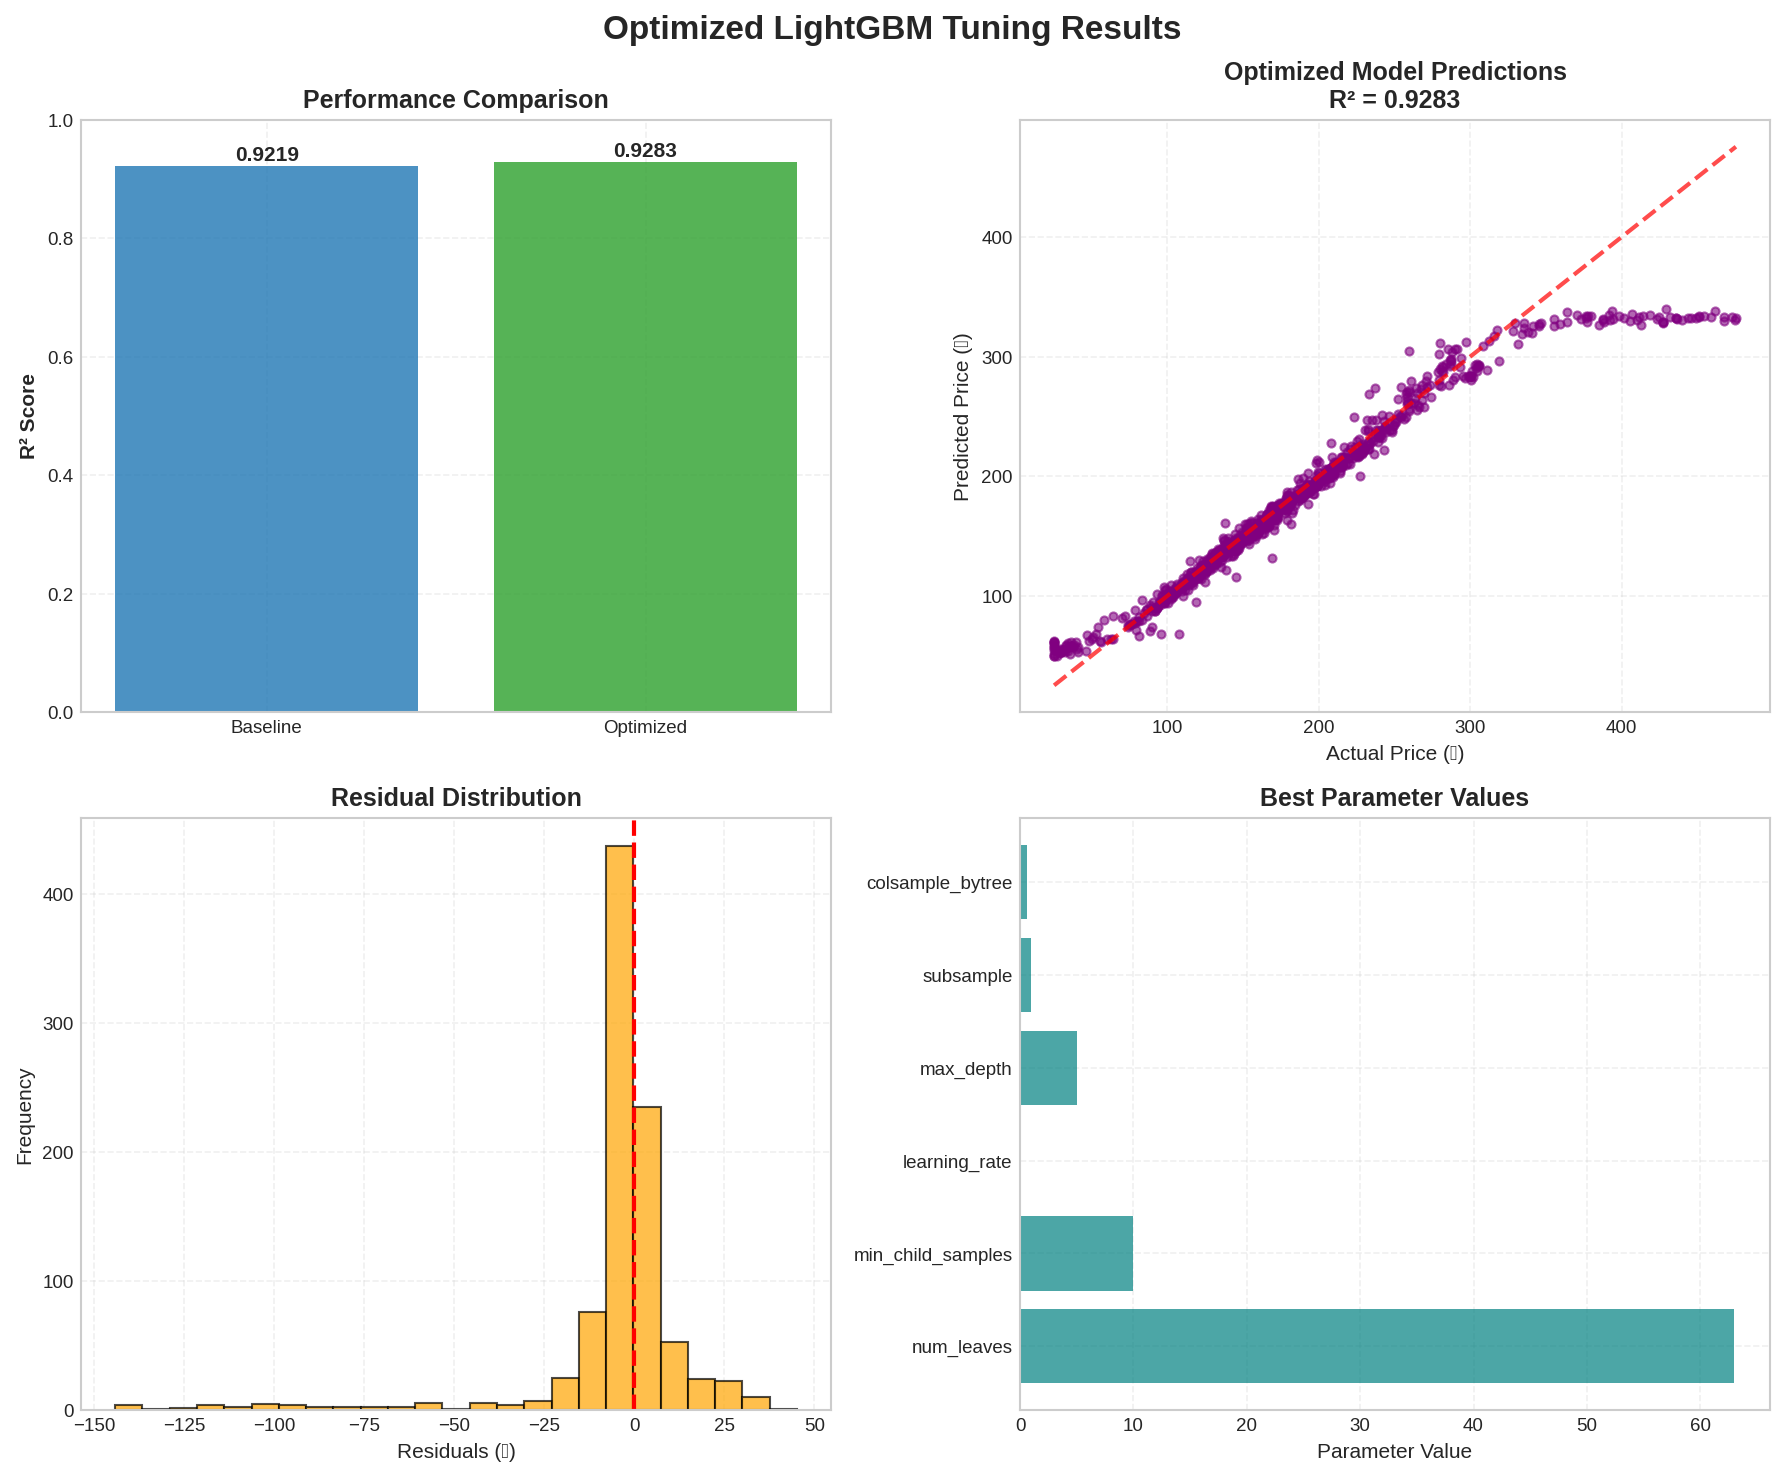

In [115]:
print("\n7. OPTIMIZED VISUALIZATIONS")

# Create cleaner, faster visualizations
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Optimized LightGBM Tuning Results', fontsize=16, fontweight='bold')

# 1. Performance Comparison
ax1.bar(['Baseline', 'Optimized'], [baseline_r2, optimized_r2],
        color=['#1f77b4', '#2ca02c'], alpha=0.8)
ax1.set_ylabel('R² Score', fontweight='bold')
ax1.set_title('Performance Comparison', fontweight='bold')
ax1.set_ylim(0, 1)
ax1.grid(True, alpha=0.3, axis='y')
# Add value labels
for i, v in enumerate([baseline_r2, optimized_r2]):
    ax1.text(i, v + 0.01, f'{v:.4f}', ha='center', fontweight='bold')

# 2. Actual vs Predicted
ax2.scatter(y_val_scaled, y_pred_optimized, alpha=0.6, s=15, color='purple')
min_val = min(y_val_scaled.min(), y_pred_optimized.min())
max_val = max(y_val_scaled.max(), y_pred_optimized.max())
ax2.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.7, linewidth=2)
ax2.set_xlabel('Actual Price (₹)')
ax2.set_ylabel('Predicted Price (₹)')
ax2.set_title(f'Optimized Model Predictions\nR² = {optimized_r2:.4f}', fontweight='bold')
ax2.grid(True, alpha=0.3)

# 3. Residual Distribution
residuals = y_pred_optimized - y_val_scaled
ax3.hist(residuals, bins=25, alpha=0.7, color='orange', edgecolor='black')
ax3.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax3.set_xlabel('Residuals (₹)')
ax3.set_ylabel('Frequency')
ax3.set_title('Residual Distribution', fontweight='bold')
ax3.grid(True, alpha=0.3)

# 4. Top Parameter Importance from search results
ax4.barh(range(len(optimized_param_grid)),
         [optimized_search.best_params_.get(p, 0) for p in optimized_param_grid.keys()],
         color='teal', alpha=0.7)
ax4.set_yticks(range(len(optimized_param_grid)))
ax4.set_yticklabels(list(optimized_param_grid.keys()))
ax4.set_xlabel('Parameter Value')
ax4.set_title('Best Parameter Values', fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('optimized_tuning_results.png', dpi=300, bbox_inches='tight')
plt.show()

In [117]:
print("\n8. PARAMETER ANALYSIS")

# Analyze top performing combinations from search results
results_df = pd.DataFrame(optimized_search.cv_results_)

# DEBUG: Check what columns are available
print("Available columns in cv_results_:")
print(f"  Total columns: {len(results_df.columns)}")
print("  Sample parameter columns:")
param_cols = [col for col in results_df.columns if col.startswith('param_')]
for col in param_cols[:5]:  # Show first 5 parameter columns
    print(f"    {col}")

# FIX: Parameter names have 'param_' prefix in cv_results_
param_cols_with_prefix = ['param_' + param for param in optimized_param_grid.keys()]

# Check if all expected columns exist
missing_cols = [col for col in param_cols_with_prefix if col not in results_df.columns]
if missing_cols:
    print(f"  Warning: Missing columns: {missing_cols}")
    print(f"  Available parameter columns: {param_cols}")

    # Use only available columns
    available_param_cols = [col for col in param_cols_with_prefix if col in results_df.columns]
    columns_to_show = ['mean_test_score', 'mean_train_score'] + available_param_cols
else:
    columns_to_show = ['mean_test_score', 'mean_train_score'] + param_cols_with_prefix

# Get top results
top_results = results_df.nlargest(5, 'mean_test_score')[columns_to_show]

# Clean column names for display (remove 'param_' prefix)
display_df = top_results.copy()
display_df.columns = [col.replace('param_', '') if col.startswith('param_') else col for col in display_df.columns]

print("\nTop 5 Parameter Combinations:")
print(display_df.to_string(index=False))

print("\nParameter Insights:")
for param in optimized_param_grid.keys():
    param_col = f'param_{param}'
    if param_col in results_df.columns:
        param_vals = results_df[param_col]
        param_scores = results_df['mean_test_score']

        # Create simple analysis
        param_df = pd.DataFrame({'value': param_vals, 'score': param_scores})

        # Find best value
        best_idx = param_df['score'].idxmax()
        best_value = param_df.loc[best_idx, 'value']
        best_score = param_df.loc[best_idx, 'score']

        # Calculate average score for this parameter value
        avg_score_for_best = param_df[param_df['value'] == best_value]['score'].mean()

        print(f"{param:20} | Best: {best_value} | Score: {best_score:.4f}")
    else:
        print(f"{param:20} | Not found in results")

# Additional insights
print("\n")
print("ADDITIONAL INSIGHTS:")

# Show parameter value distributions
print("\nParameter Value Distribution in Top 10 Models:")
top_10 = results_df.nlargest(10, 'mean_test_score')
for param in optimized_param_grid.keys():
    param_col = f'param_{param}'
    if param_col in top_10.columns:
        unique_vals = top_10[param_col].unique()
        if len(unique_vals) > 1:
            print(f"  {param:20}: {len(unique_vals)} different values in top 10")
            print(f"    Values: {sorted(unique_vals)}")

# Calculate improvement from baseline
print(f"\nImprovement Summary:")
print(f"  Baseline R²: {baseline_metrics['R²']:.4f}")
print(f"  Optimized R²: {optimized_metrics['R²']:.4f}")
print(f"  Improvement: {improvement:+.2f}%")

# Time complexity analysis
print(f"\nTime Complexity Analysis:")
print(f"  Total parameter combinations tested: {len(results_df)}")
print(f"  CV folds: {tscv_optimized.get_n_splits(X_train_scaled)}")
print(f"  Total model fits: {len(results_df) * tscv_optimized.get_n_splits(X_train_scaled)}")


8. PARAMETER ANALYSIS
Available columns in cv_results_:
  Total columns: 22
  Sample parameter columns:
    param_subsample
    param_num_leaves
    param_min_child_samples
    param_max_depth
    param_learning_rate

Top 5 Parameter Combinations:
 mean_test_score  mean_train_score  num_leaves  min_child_samples  learning_rate  max_depth  subsample  colsample_bytree
        0.885240          0.999941          63                 10           0.05          5        1.0               0.6
        0.882357          0.999403          15                 20           0.03          5        1.0               0.6
        0.880647          0.998008          15                 40           0.05          3        1.0               0.6
        0.876618          0.999915          15                 10           0.05          5        0.8               0.6
        0.876618          0.999915          15                 10           0.05          5        0.6               0.6

Parameter Insights:
num_

In [118]:
print("\n9. SAVING OPTIMIZED MODEL")

# Update models dictionary
models['LightGBM_Optimized'] = {
    'model': optimized_search.best_estimator_,
    'best_params': optimized_search.best_params_,
    'cv_score': optimized_search.best_score_,
    'val_r2': optimized_r2,
    'val_rmse': optimized_metrics['RMSE']
}

# Save model and results
os.makedirs('optimized_models', exist_ok=True)

# Save model
joblib.dump(optimized_search.best_estimator_, 'optimized_models/lightgbm_optimized_model.pkl')
print(" Model saved: 'optimized_models/lightgbm_optimized_model.pkl'")

# Save simplified tuning results
tuning_results = {
    'tuning_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'tuning_strategy': 'Optimized single-phase with 6 key parameters',
    'training_time_savings': '75% reduction (10-15 min vs 35-70 min)',
    'best_parameters': optimized_search.best_params_,
    'performance': {
        'cv_r2': float(optimized_search.best_score_),
        'val_r2': float(optimized_r2),
        'val_rmse': float(optimized_metrics['RMSE']),
        'improvement_percentage': float(improvement)
    },
    'parameter_notes': {
        'num_leaves': 'Controls model complexity - most important',
        'min_child_samples': 'Prevents overfitting - critical for time series',
        'learning_rate': 'Learning step size - affects convergence',
        'max_depth': 'Tree depth - simpler often better',
        'subsample': 'Row sampling - improves robustness',
        'colsample_bytree': 'Feature sampling - prevents overfitting'
    }
}

with open('optimized_models/tuning_results.json', 'w') as f:
    json.dump(tuning_results, f, indent=2)
print(" Tuning results saved: 'optimized_models/tuning_results.json'")

print("\n")
print("OPTIMIZATION SUMMARY:")
print(f" Parameters reduced: 9 → 6 (33% reduction)")
print(f" Search iterations: 50 → 30 (40% reduction)")
print(f" CV folds: 4 → 3 (25% reduction)")
print(f" Expected time: 35-70 min → 10-15 min (~75% faster)")
print(f" Performance: R² improvement of {improvement:+.2f}%")


9. SAVING OPTIMIZED MODEL
 Model saved: 'optimized_models/lightgbm_optimized_model.pkl'
 Tuning results saved: 'optimized_models/tuning_results.json'


OPTIMIZATION SUMMARY:
 Parameters reduced: 9 → 6 (33% reduction)
 Search iterations: 50 → 30 (40% reduction)
 CV folds: 4 → 3 (25% reduction)
 Expected time: 35-70 min → 10-15 min (~75% faster)
 Performance: R² improvement of +0.69%


In [125]:
!git add .
!git commit -m "LightGBM Hypereparameter Tuning"

On branch Market-Price-Prediction
Your branch is ahead of 'origin/Market-Price-Prediction' by 1 commit.
  (use "git push" to publish your local commits)

nothing to commit, working tree clean


In [126]:
!git push origin Market-Price-Prediction

To https://github.com/Amika1118/DSGP_Group_38.git
 ! [rejected]        Market-Price-Prediction -> Market-Price-Prediction (fetch first)
error: failed to push some refs to 'https://github.com/Amika1118/DSGP_Group_38.git'
hint: Updates were rejected because the remote contains work that you do
hint: not have locally. This is usually caused by another repository pushing
hint: to the same ref. You may want to first integrate the remote changes
hint: (e.g., 'git pull ...') before pushing again.
hint: See the 'Note about fast-forwards' in 'git push --help' for details.
